In [50]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [47]:
nc_file = "NRM2.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

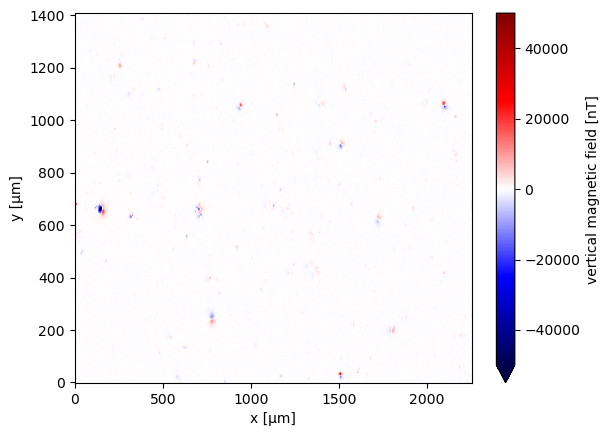

In [48]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [49]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 52.8 48.71 66.73 83.59 ... 182.6 117.5 76.16

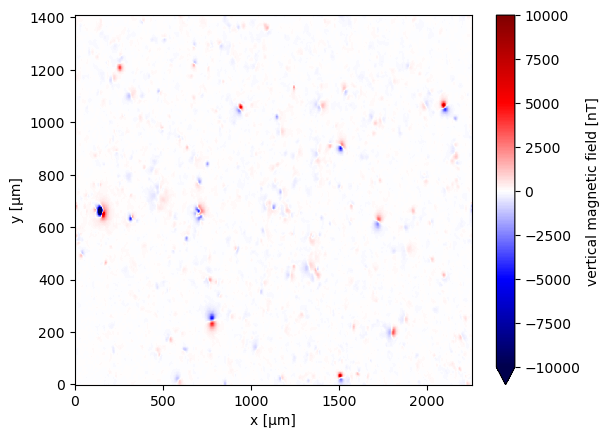

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 52.8 48.71 66.73 83.59 ... 182.6 117.5 76.16
    tga      (y, x) float64 5MB 8.306 12.94 8.112 13.35 ... 35.3 24.31 18.76
    x_deriv  (y, x) float64 5MB -1.742 2.964 7.421 ... -28.87 -22.66 -17.61
    y_deriv  (y, x) float64 5MB -1.673 -0.2701 -1.661 ... 12.36 8.388 3.543
    z_deriv  (y, x) float64 5MB 7.947 12.59 -2.824 -12.35 ... -16.12 2.708 5.416

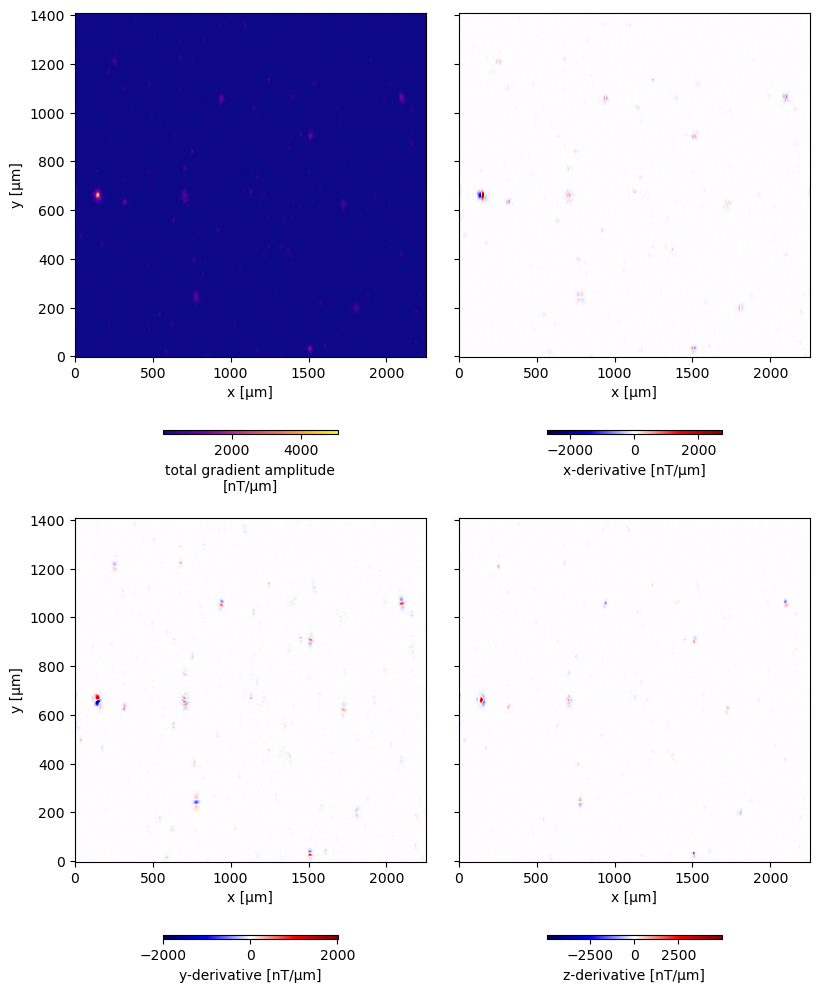

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

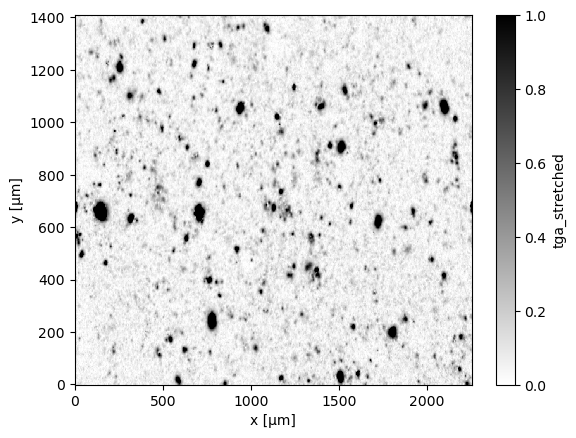

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 500],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

330 potential sources detected within 7.013 seconds


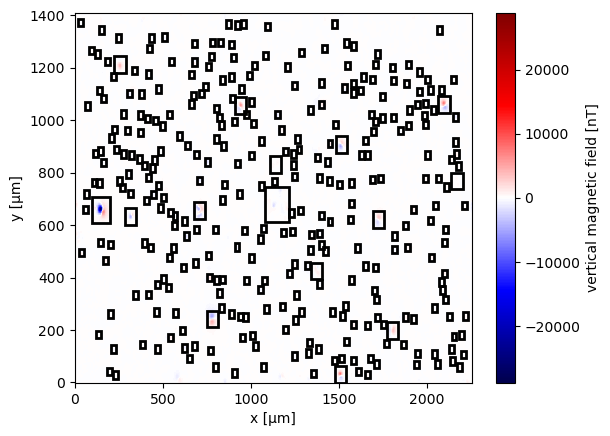

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

330 euler positions and dipole moments estimated within 1.77 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 103.9712 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z          bz    z_deriv
0  737.90  827.2  10.0   47.903842 -17.954781
1  740.25  827.2  10.0    3.191443 -18.345309
2  742.60  827.2  10.0  -47.815770 -15.577690
3  744.95  827.2  10.0  -95.371543 -12.839816
4  747.30  827.2  10.0 -128.834331 -20.414988

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

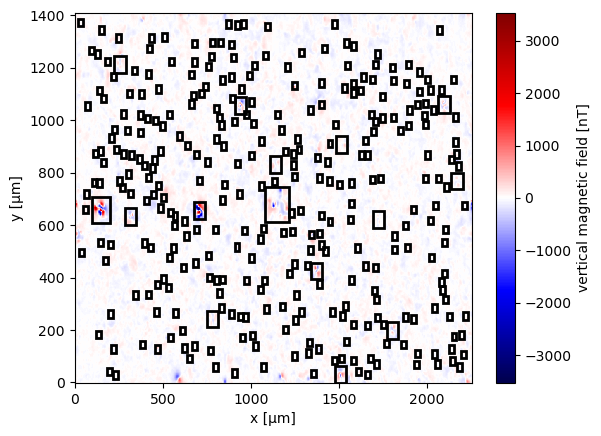

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

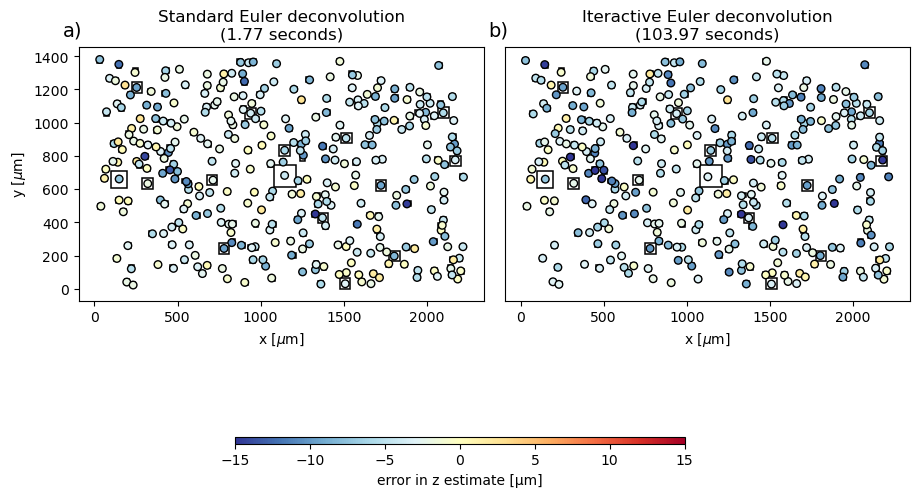

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

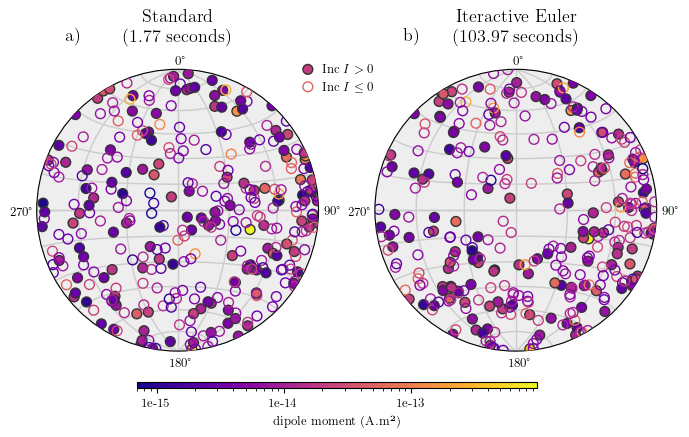

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

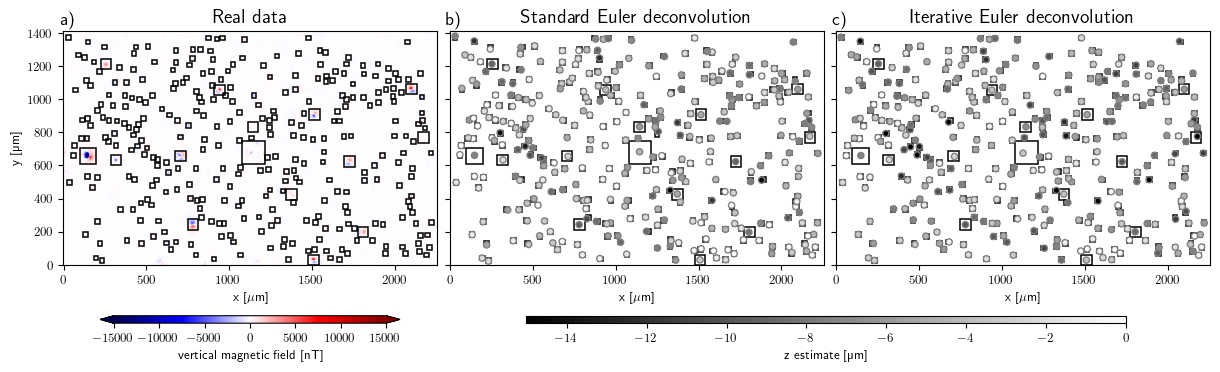

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


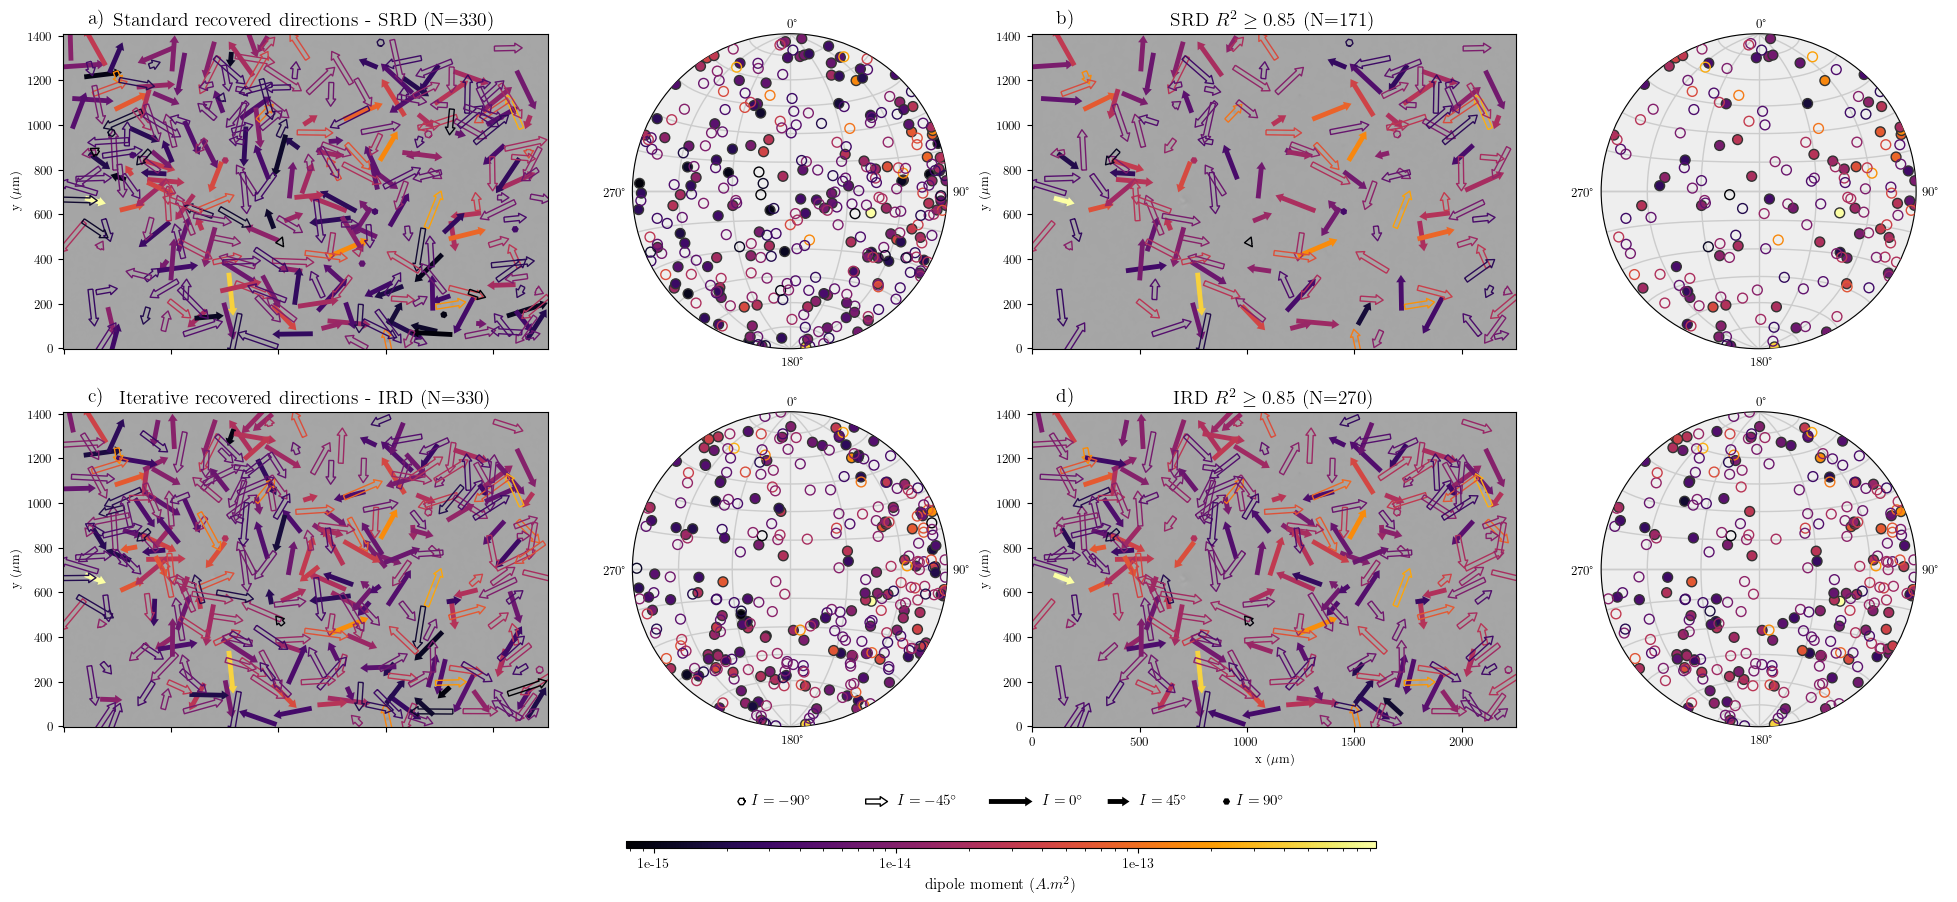

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

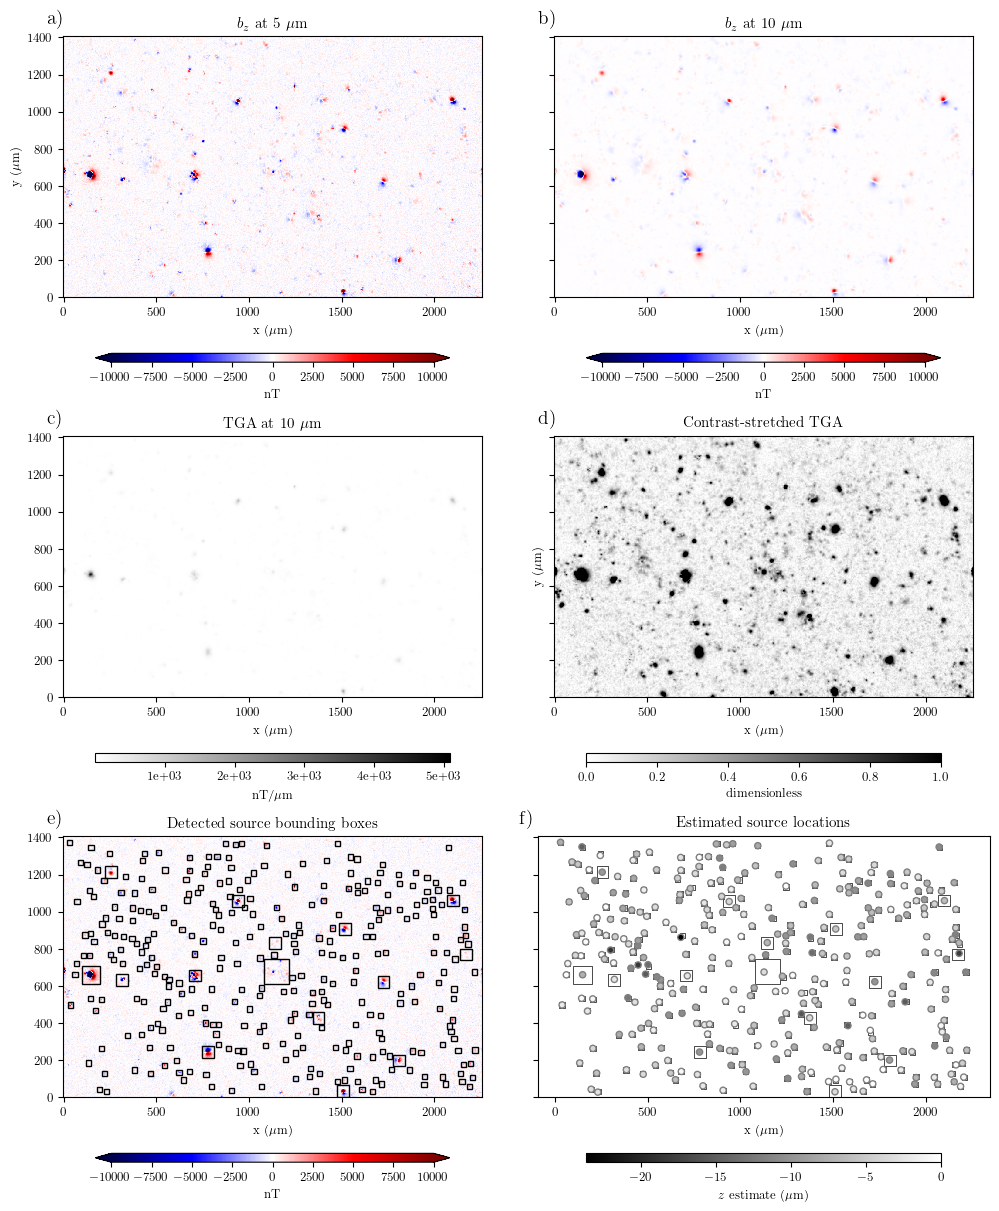

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [30]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [31]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 49.85 44.77 61.9 77.93 ... 181.7 115.9 73.35
    tga      (y, x) float64 5MB 8.169 12.71 7.729 13.3 ... 35.67 24.74 19.23
    x_deriv  (y, x) float64 5MB -2.165 2.562 7.057 ... -29.13 -23.05 -18.09
    y_deriv  (y, x) float64 5MB -1.237 0.2909 -0.9857 ... 12.53 8.628 3.902
    z_deriv  (y, x) float64 5MB 7.779 12.45 -2.993 -12.55 ... -16.34 2.454 5.242

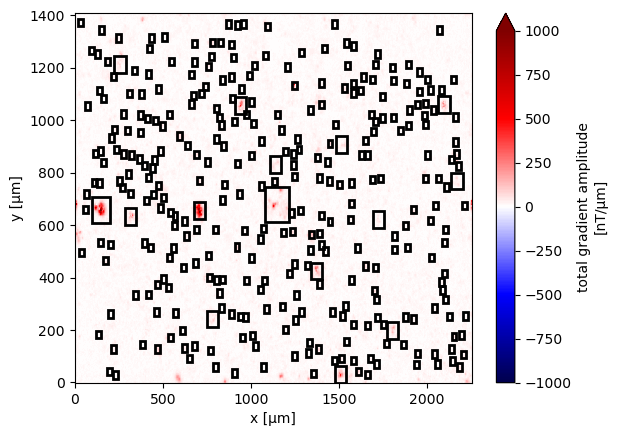

In [32]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [33]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [34]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.1,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [35]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

575 potential sources detected within 1.312 seconds


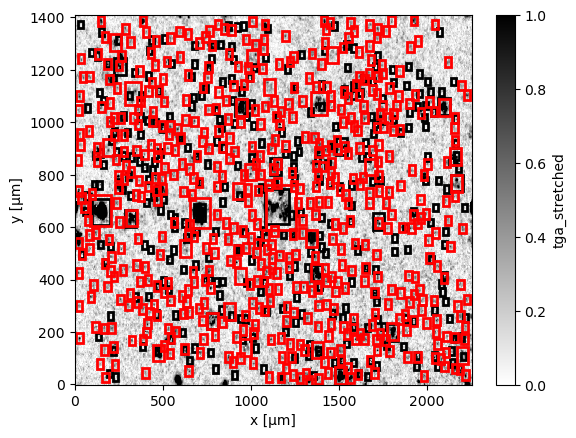

In [36]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [37]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 367.01522369  403.78477631 1368.11522369 1404.88477631]
[1151.91522369 1188.68477631    7.46522369   44.23477631]
[1549.06522369 1585.83477631    5.11522369   41.88477631]
[ 129.66522369  166.43477631 1368.11522369 1404.88477631]
[1908.61522369 1945.38477631 1370.46522369 1407.23477631]
[  2.76522369  39.53477631 522.11522369 558.88477631]
[2211.76522369 2248.53477631 1086.11522369 1122.88477631]
[1398.66522369 1435.43477631 1368.11522369 1404.88477631]
[1260.01522369 1296.78477631    5.11522369   41.88477631]
[   7.46522369   44.23477631 1081.41522369 1118.18477631]
[  2.76522369  39.53477631 719.51522369 756.28477631]
[743.01522369 779.78477631 416.36522369 453.13477631]
[752.41522369 789.18477631 348.21522369 384.98477631]
[1119.01522369 1155.78477631  914.56522369  951.33477631]
[1628.96522369 1665.73477631  996.81522369 1033.58477631]
[  7.46522369  44.23477631 157.86522369 194.63477631]
[900.46522369 937.23477631 162.56522369 199.33477631]
[1929.7652236

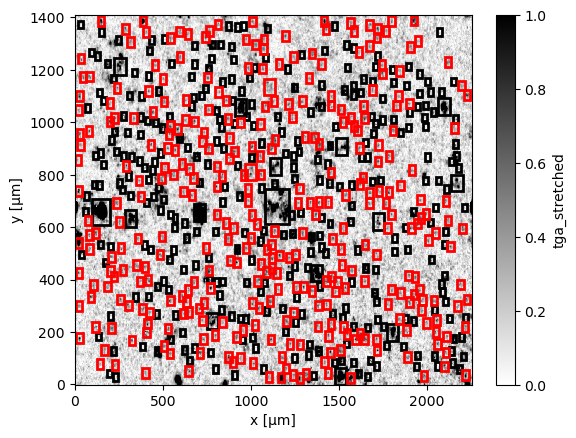

In [38]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

piorou

[3.86442296e+02 1.38357382e+03 8.45229862e-01]

[2.90901634e-15 3.18657897e-15 4.45812752e-17]

(-0.5919823560410667, 42.39284046696817, 4.314933263019452e-15)

0.8464216396404991

[1172.43522742   24.40234812   -1.76614145]

[ 1.51299725e-14  5.79743552e-15 -1.38358744e-15]

(4.880794511008448, 69.03438910670586, 1.6261630925084497e-14)

0.9897543080011294

[1563.68607958   21.93951414   -8.71692259]

[ 2.04535034e-14  1.07113115e-14 -4.32272537e-16]

(1.0725910343602252, 62.35936290441084, 2.309252813878712e-14)

0.920642148654828

[ 152.24133586 1386.13989035   -4.70617343]

[-4.89126332e-15 -1.15533208e-15  2.86493585e-15]

(-29.68483324041274, -103.28986447794317, 5.7850761886268294e-15)

0.8232401523893662

piorou

[1925.28232153 1388.83534108   -4.1035908 ]

[5.77235440e-16 2.74778712e-15 4.99331907e-15]

(-60.65077775827904, 11.863776139608298, 5.728592333159646e-15)

0.653776151446029

[ 20.28042817 546.46756354  -1.95356924]

[-2.75186102e-16 -9.64663801e-15  4.99872571e-16]

(-2.965113858505605, -178.36598746616767, 9.663499618689779e-15)

0.8749075204693463

piorou

[ 2.22705885e+03  1.10169842e+03 -8.29334450e-01]

[-2.18925928e-15 -7.81960172e-16 -7.58634046e-16]

(18.07324799730352, -109.65572397848673, 2.4453718609973606e-15)

0.8022728474589603

[1415.816832   1386.78566388   -7.1209022 ]

[ 9.51017722e-15 -1.32623429e-15  5.01153259e-15]

(-27.560717591486558, 97.93893799075299, 1.0831335424588153e-14)

0.9465538791245243

[1278.31548606   18.38790086   -7.06317965]

[5.59938639e-15 1.03187426e-14 3.40885244e-15]

(-16.191190720664316, 28.486130785418755, 1.2224968370009076e-14)

0.9281162907166527

[  24.63196398 1099.88850177   -3.86205493]

[ 1.99663203e-15  3.14128168e-15 -1.35414425e-15]

(19.99188119327607, 32.44047338832596, 3.960794957470622e-15)

0.8155801634204294

[ 18.9310319  737.21696065  -2.92227174]

[ 1.06466826e-16 -3.42417949e-15  1.30945982e-15]

(-20.918402448745677, 178.21909594066497, 3.6675639552748566e-15)

0.9059992472814763

[756.12318423 424.67529651 -12.84519302]

[-1.99832360e-14 -2.98772163e-14 -4.32169823e-15]

(6.855984013724229, -146.2236006063706, 3.6202967412379785e-14)

0.9426586426939889

piorou

[7.69829128e+02 3.64786600e+02 4.21071139e-01]

[3.24623809e-16 5.18601513e-16 9.11510244e-16]

(-56.12971012699877, 32.044920009917114, 1.0978064820496612e-15)

0.6000005001416171

[1134.97842339  936.17424721   -2.68698141]

[-1.25450163e-15  3.32465963e-15  5.97372533e-16]

(-9.542749516430197, -20.6731136943968, 3.603330392114516e-15)

0.8710734642903448

[1647.5176206  1018.27309759   -8.77353606]

[ 6.34108129e-15  1.08682924e-14 -3.78416583e-17]

(0.17231025365460173, 30.261330157797836, 1.2582945778947361e-14)

0.926339819001949

[ 23.75363283 175.03462253   0.61079844]

[-7.63383241e-16  3.22928238e-16 -4.67101917e-16]

(29.402827235681404, -67.07054752710643, 9.514309329049154e-16)

0.8166055467984594

[917.60070406 180.73791136  -3.88570854]

[ 2.01957688e-15 -3.26380394e-15  1.95645263e-18]

(-0.02920614521481834, 148.25160304859537, 3.8381129141396445e-15)

0.9148712257585286

[1954.07778657  616.73128194   -8.12587707]

[-8.46009457e-15 -5.01324463e-15  4.37118003e-15]

(-23.965177263714136, -120.64994244476375, 1.0761646560125784e-14)

0.9226829176987914

[1424.11215685  398.87010795   -7.94168903]

[-3.70155901e-15  4.00616051e-15 -5.29859155e-15]

(44.16967129996602, -42.73690480520299, 7.6043364979021e-15)

0.8141279917889598

[713.08230311 122.85900423  -1.22214085]

[ 1.84599702e-15 -2.60543482e-16  1.80274061e-16]

(-5.523235422540121, 98.03364554758637, 1.8729886970177992e-15)

0.8464714250651888

[1646.29625898  175.77616195  -11.48118914]

[ 1.17107305e-14 -1.84141204e-14  1.49803741e-15]

(-3.9269937454050106, 147.54507974273972, 2.187384639037273e-14)

0.9603663079917425

[1122.37754557  906.4836305    -7.24915084]

[1.97553879e-15 6.65308495e-15 9.83238122e-16]

(-8.06360203317216, 16.53803676338435, 7.009497132562919e-15)

0.7746786029710294

[1608.97132529  966.39724966   -4.72753007]

[-1.74865647e-15  3.66391889e-15  1.84230346e-15]

(-24.408069882329354, -25.513461715628242, 4.458271313803502e-15)

0.7846282460146699

[416.56807323 396.78228421  -6.53313064]

[ 3.51701859e-15 -6.32525478e-15  3.09325690e-16]

(-2.4473654015045176, 150.9247163762763, 7.243890538860458e-15)

0.9205751748683317

[1165.28974935  488.19753531   -8.85203914]

[ 3.21783998e-15 -8.01309327e-15 -5.30082700e-15]

(31.544642671520307, 158.12094944302473, 1.0132271453921117e-14)

0.9387349489705582

[2123.28009395 1229.69511464   -6.83103966]

[ 6.83419978e-15  8.58776809e-16 -1.63268534e-15]

(13.335006342533221, 82.83782533921735, 7.07880256000664e-15)

0.9292114589722962

[1346.92836079 1272.54753602   -6.88941689]

[ 7.01310719e-15  4.02905950e-15 -1.56241280e-15]

(10.933429873663185, 60.12245175453153, 8.237604425747687e-15)

0.6841102433844575

[117.25096948 577.64147682  -5.88215207]

[-6.41652847e-16 -3.90495935e-15 -2.27042676e-15]

(29.844081356313666, -170.66869149283085, 4.562374779201147e-15)

0.7600992533370601

piorou

[913.65428167 883.93237859  -2.18374431]

[ 7.20375010e-16  1.08375857e-15 -2.61360279e-16]

(11.356208957550994, 33.61201147297402, 1.3273213612693947e-15)

0.17799454386569413

[1713.53952728  128.33017412   -3.46269741]

[-2.50200294e-15 -7.06623904e-16 -8.76247425e-17]

(1.9303364317619358, -105.77091561888406, 2.6013485214986182e-15)

0.7566713261320289

[675.87345527 999.93045526  -3.87368956]

[2.37552290e-15 2.44688312e-15 7.69042138e-16]

(-12.707853922103572, 44.1522195774718, 3.4959650838192038e-15)

0.8550441373793338

[1202.40148145 1332.32013147   -8.57906103]

[ 1.79253701e-15  7.67954085e-15 -3.37864058e-15]

(23.19207627038261, 13.138579961629173, 8.579262717107208e-15)

0.8819051052519881

[  81.57635996 1173.75375091   -2.95914125]

[ 2.71196019e-15 -2.32862597e-16 -7.20302386e-16]

(14.82233053419474, 94.90766749251904, 2.815632894562376e-15)

0.910950350749646

[ 91.37889274 335.17298895   3.67415121]

[ 2.78816403e-16 -3.05221978e-17  9.44815597e-17]

(-18.61631373278308, 96.24732678447926, 2.9596783025473325e-16)

0.4176877606808752

[2203.25137369  596.11604501  -12.09763025]

[ 8.61787474e-15 -1.92508966e-14 -5.35923699e-16]

(1.4555198823112792, 155.88380123753052, 2.1098625558372897e-14)

0.9852812351511397

piorou

[1352.60531881  943.68437603   -5.24549587]

[-2.38454747e-15  3.18774289e-15 -2.03780121e-16]

(2.930363169940331, -36.79782306322706, 3.986138198282571e-15)

0.20368719596372897

[1904.32725391  317.48166222  -11.3741839 ]

[-5.24804038e-15 -1.18231749e-14  5.23986483e-15]

(-22.051571425331563, -156.0646458557972, 1.395656027821273e-14)

0.9478426488838886

[ 2.05961386e+03  2.43792979e+02 -1.26410584e-01]

[ 7.68707615e-16  7.88868249e-16 -4.28280563e-16]

(21.24748598903414, 44.258427943642786, 1.1817989480967013e-15)

0.569522600288378

[ 220.4065737  1010.92665981   -3.02297669]

[1.31596483e-15 2.72979031e-15 2.68381497e-16]

(-5.061031769269613, 25.737573629056307, 3.0422930829752353e-15)

0.7700336070936377

[1714.31528401 1353.81045203   -5.85392788]

[-5.63009469e-15 -2.38927368e-16 -2.53336208e-15]

(24.20693424482951, -92.43003384104766, 6.1784282752893794e-15)

0.9088105410497442

[233.19782405 692.23794573  -6.09199751]

[6.14619573e-15 2.93275224e-16 1.95238103e-15]

(-17.604014901647787, 87.26811548916598, 6.455503386227782e-15)

0.882125248100482

[1387.05408165  914.51984925   -9.87359897]

[ 1.12163027e-14 -1.39152539e-14  2.65956969e-15]

(-8.463780185571913, 141.129667845238, 1.8069672046996327e-14)

0.9232487374149472

[1109.97268031  320.95662359  -11.92625686]

[-1.23622380e-14 -1.45025030e-14  5.35178988e-15]

(-15.686816307244053, -139.5550297634898, 1.9793665089805585e-14)

0.8811022678013471

[760.42536969 895.65105096  -5.23782338]

[ 4.03872422e-15  3.30637396e-15 -4.46650795e-16]

(4.891063976829881, 50.69391373273518, 5.238597048506016e-15)

0.8568920505867542

[1458.41752051  119.78090418   -5.83062813]

[-1.46703202e-15  5.31185445e-15 -1.16538203e-16]

(1.2114856148732625, -15.43912848485856, 5.5119471921069304e-15)

0.7603447572491053

[ 1.59610566e+03  1.72689759e+02 -3.19651027e-02]

[-4.45285608e-16 -4.74240333e-17 -8.80098710e-16]

(63.03250883181641, -96.07922811513966, 9.87472557166347e-16)

0.8890821103461023

[1787.96751231  736.05906154   -4.18202408]

[-1.72905234e-15 -3.36261000e-15  2.90126906e-16]

(-4.3877467654249935, -152.787795631427, 3.792221196576067e-15)

0.8689418293229048

[1068.00342927 1281.17869096  -12.29136094]

[1.32394927e-14 6.66143309e-15 9.05741285e-15]

(-31.43013045272574, 63.290806538997316, 1.7369386473483197e-14)

0.9616966564320241

[917.97028525 465.29657772  -3.84699337]

[-1.53930470e-15 -1.37398222e-15 -2.38587366e-15]

(49.146534901873885, -131.7520768955637, 3.154311215127308e-15)

0.8466019679175779

[836.30114193 795.67022915  -2.89378002]

[ 1.10087838e-15  2.36011035e-15 -5.67691159e-16]

(12.29738538203514, 25.006796495435403, 2.6653944026055824e-15)

0.8678874239359837

piorou

[1805.57894248  969.76821027   -3.24897128]

[2.06854028e-15 9.80089288e-17 2.25186550e-15]

(-47.39773399347059, 87.28731340991754, 3.0593075833733314e-15)

0.7597612203851918

piorou

[1082.56453217  430.98863552   -6.57605661]

[ 7.56926281e-15  1.85189799e-15 -1.00227216e-15]

(7.3291376648827375, 76.25206282036613, 7.856705105398159e-15)

0.5957757502699057

[1669.66428987  730.9218381    -7.37712029]

[4.55035927e-15 1.46791998e-15 3.90875083e-15]

(-39.26643856392573, 72.12059456195718, 6.175669323000269e-15)

0.8165250479472506

[1768.59607531  692.93144496   -5.30155543]

[-1.50489557e-15  4.77555301e-15 -6.31602399e-16]

(7.1894577278944665, -17.49093631323388, 5.046735458723529e-15)

0.8535488245321868

piorou

[ 438.81068264 1029.32800855   -1.56669566]

[1.45598372e-15 1.02799634e-15 5.84506191e-17]

(-1.8783235989666993, 54.77602188051044, 1.783278306655724e-15)

0.4301146709217095

[ 1.45954506e+03  4.11412733e+02 -1.30650329e+00]

[-1.04054655e-15 -1.53188880e-15 -4.58250906e-16]

(13.898820788219576, -145.81340877160048, 1.907724903931764e-15)

0.8985312176632679

[ 289.30955233 1348.06496167   -8.82492592]

[-9.86633677e-15  1.22015554e-15  1.54049674e-15]

(-8.808282278823626, -82.95010886164641, 1.0060144677874103e-14)

0.8394228935331927

[1110.21873843  166.41303917   -8.79508768]

[-2.16834051e-15 -6.95968650e-15 -4.08696397e-15]

(29.277313414485665, -162.695200602431, 8.357165260022323e-15)

0.872491133667906

[407.63034921 236.3157397   -4.96447331]

[ 2.20108469e-15 -4.14535779e-15 -7.88454448e-16]

(9.53603762149569, 152.03277926954985, 4.759246310970089e-15)

0.7442910969239828

piorou

[ 1.61633398e+03  7.71319919e+02 -1.55347251e+00]

[ 8.51638925e-16 -2.83027859e-16  8.33744005e-16]

(-42.89293632055417, 108.3833584678595, 1.2249582419232372e-15)

0.35147525383889433

piorou

[1421.98714762 1357.27443568   -2.86371605]

[-8.91474362e-17  2.98223100e-15 -6.11297164e-16]

(11.578983990016997, -1.7122252652467411, 3.04554317092497e-15)

0.6851232838755366

piorou

[ 1.36150930e+03  6.41952319e+02 -4.83220535e-01]

[-1.06500858e-15 -2.48898655e-16  1.09345682e-16]

(-5.70929831381293, -103.15425813755657, 1.0991589039543159e-15)

0.28770474734723617

[1381.37118689  697.20761545   -1.92837821]

[ 1.42814568e-15 -1.41685326e-15  3.98870855e-16]

(-11.214711476001437, 134.7725817549842, 2.0508952166247244e-15)

0.772265127218849

[ 4.86111407e+02  4.93944113e+02 -2.17403771e-01]

[-4.43640074e-16  9.76270981e-16  5.95097820e-16]

(-29.02810677074317, -24.438143970727666, 1.226402445343448e-15)

0.7410790761366841

[1509.63446175  132.90870204   -9.3768078 ]

[-1.05555236e-14 -1.19929324e-14 -5.50851902e-17]

(0.19754830593274258, -138.64752994543457, 1.5976624796439158e-14)

0.9155041460883073

[1204.1076808   239.03580977   -7.5396758 ]

[ 4.66049310e-15 -6.94075812e-15 -2.92507795e-15]

(19.28381336006147, 146.11992511487162, 8.857223056030488e-15)

0.8531124345402731

[ 24.37138267 952.45112416  -4.57266877]

[6.12881356e-16 3.34236443e-15 1.16421924e-15]

(-18.91196105384533, 10.39075748331573, 3.591995268741615e-15)

0.842299620691021

[1039.1448784   395.24200689   -2.3314303 ]

[ 2.68952636e-15  1.12437619e-15 -5.97996497e-17]

(1.1751891673865071, 67.3122765646767, 2.9157074340233147e-15)

0.8666728148417899

[546.13624872 321.49308503  -5.89424877]

[ 5.18293513e-15  1.72914029e-15 -1.00733787e-15]

(10.44614267615749, 71.5501759575395, 5.555850273448636e-15)

0.9257837048378983

[ 202.52165359 1004.73390832   -1.43286263]

[ 7.10172283e-16  1.20996516e-15 -1.09680135e-15]

(38.01701602815948, 30.410212812625502, 1.7808238418303262e-15)

0.8190521337610541

[866.15370249  94.49642089 -10.89786858]

[ 1.13995415e-14 -9.76901876e-15  2.35312609e-15]

(-8.908154044766675, 130.5954504604625, 1.519606781763553e-14)

0.7617695425761309

[ 750.97225954 1171.99136238   -6.43924996]

[ 5.91765623e-15 -3.72676307e-16  1.09678159e-15]

(-10.479782610594487, 93.60355799271213, 6.0299645721278015e-15)

0.9450811686441313

[ 539.8456817  1318.92899062   -2.57854133]

[ 6.00496674e-17 -1.94363144e-15 -8.68384579e-16]

(24.06417780841838, 178.23037519455883, 2.1296480708240876e-15)

0.6211054434800831

piorou

[ 2.21567587e+03  3.11031794e+01 -3.17284025e-01]

[ 1.92198044e-15 -1.23806323e-16  7.89188051e-16]

(-22.28198594772959, 93.68567369087137, 2.0813828536024254e-15)

0.6713554384731266

[1027.40850823 1299.35439786  -11.92469787]

[-3.11201566e-15 -1.72258611e-14  7.37116656e-15]

(-22.835771643942437, -169.75942913620776, 1.8993394356831872e-14)

0.9262071810962247

[ 1.67356849e+03  1.36911618e+03 -1.62587771e+00]

[-1.33279194e-15 -1.18475870e-15  2.67938619e-16]

(-8.544931356347766, -131.63485436957487, 1.803268873652795e-15)

0.7402696054923552

[489.28545194 781.61759846 -11.1742442 ]

[ 1.60395952e-14 -3.34381243e-15  2.46806171e-15]

(-8.566318586449487, 101.77592358122314, 1.6569279511549377e-14)

0.8990743824949521

piorou

[ 2.23098649e+03  3.19790869e+02 -4.92926839e-01]

[ 1.32958167e-15 -1.85250751e-17 -5.41473315e-16]

(22.156711660681776, 90.79825103418901, 1.4357311536586887e-15)

0.5037615849800202

[566.805681   798.48852266  -8.93232775]

[-6.45512167e-15  3.07703079e-15  5.14073498e-15]

(-35.71175274293365, -64.51377151711466, 8.80703527692453e-15)

0.826639550028552

[ 1.99093990e+03  2.75795154e+01 -1.64802832e+00]

[9.05230876e-16 1.79905558e-15 2.62881107e-16]

(-7.436733468806451, 26.71017096077523, 2.0310466269686883e-15)

0.623993003591234

[ 872.55079407 1014.99770947   -3.93342316]

[-3.36422156e-15  1.23735246e-15  7.82849687e-16]

(-12.319689978953258, -69.80660132148574, 3.669043672528625e-15)

0.7501386459874352

piorou

[ 1.93601459e+03  4.08688219e+02 -1.38997775e+00]

[ 4.40225717e-16  2.87179523e-18 -1.35340693e-15]

(71.98137238946282, 89.62623852697386, 1.4232066795495808e-15)

0.7006756665733841

[1534.4671882   365.33752231   -6.66138827]

[-3.21025055e-15  3.75067884e-15 -1.17362298e-15]

(13.37231949274921, -40.56061136148185, 5.0745138915595675e-15)

0.8366806873101098

[1909.46591268 1283.40944225   -5.43031399]

[ 3.07544706e-15 -4.13943750e-15 -1.07949801e-15]

(11.823116262728037, 143.38903344987273, 5.268646259404613e-15)

0.9249497889781453

[2141.86581837  528.81047586   -7.10977889]

[-6.76009264e-15  1.27792835e-15  7.41016392e-16]

(-6.147551531260543, -79.29512616187961, 6.919614055106739e-15)

0.8429567859619698

[603.02229129 335.01714425  -6.9308472 ]

[3.44927774e-15 4.59344330e-15 2.01390182e-15]

(-19.320154936549258, 36.90337364065769, 6.087120732276364e-15)

0.9184647134027519

piorou

[1.12870952e+03 5.84650020e+02 4.75264860e-01]

[-6.05450702e-16 -1.54761915e-16 -4.18332087e-16]

(33.799134251762005, -104.33859997178179, 7.520129901472233e-16)

0.24125619553189281

[1616.7874642   193.81143565    1.65378076]

[-4.97650514e-16  4.84617777e-16 -1.38145670e-16]

(11.248034773275638, -45.76015587971828, 7.082334710962334e-16)

0.5367819772670042

[565.28016911 896.15684538  -5.88456816]

[-2.03423078e-15  2.69662134e-15 -2.53657428e-15]

(36.90448799740941, -37.0295430880998, 4.224224262009925e-15)

0.8234253514596628

[322.34270309 164.8506397   -3.07171828]

[-1.91310136e-16  8.91397537e-16  1.60773889e-15]

(-60.44385634843565, -12.112969557805355, 1.8482460521531295e-15)

0.8494458651330955

[2105.00330165   63.84927541  -12.10868042]

[-1.33242845e-15  1.85097943e-14 -1.15029034e-15]

(3.546916130391466, -4.117337482413532, 1.8593305789361312e-14)

0.8890730213294368

piorou

[5.41268646e+02 9.85869115e+02 2.98758546e-01]

[ 3.22025984e-16  5.99424404e-16 -2.99717774e-16]

(23.772091356341804, 28.24581909653507, 7.435328472993417e-16)

0.3186617211124191

[1572.6307582   441.34421776   -9.48369648]

[ 3.48075462e-15  8.53674782e-15 -4.58319300e-15]

(26.43386842825271, 22.182578375108445, 1.0295502614985408e-14)

0.8991338344874436

[1459.87888379  548.74452583   -7.87996163]

[-3.94671386e-15 -4.87978567e-15 -3.46672667e-15]

(28.91510104374762, -141.03447105064143, 7.169871150421276e-15)

0.8483801358367327

[2.10516985e+03 7.01714109e+02 9.16247907e-02]

[-8.70392651e-16 -3.26256582e-16 -3.17342025e-16]

(18.849924283663867, -110.54792693673238, 9.822080659139928e-16)

0.645168468757988

piorou

[1529.31559333 1003.96346449   -2.96690394]

[-5.85403455e-17 -2.70028584e-15 -4.00690646e-16]

(8.438474800206954, -178.75806132803604, 2.730480465812982e-15)

0.5895078113313732

[1292.35794091  578.94834353   -3.91401879]

[ 2.25337716e-15 -9.92666587e-16  2.39814437e-15]

(-44.243354445133946, 113.774640141395, 3.437177912085457e-15)

0.87980203963148

[730.94850845 174.08272123  -0.99257168]

[ 3.62948634e-16 -1.24582915e-15  6.36699439e-16]

(-26.135638434639056, 163.75752212717546, 1.4454093383877577e-15)

0.8513170918352939

[1112.58148738  483.01048291   -4.60439176]

[ 1.37633946e-15 -3.44134052e-15  1.78292902e-16]

(-2.754063492384034, 158.20141449618285, 3.710649978049993e-15)

0.6600705235560589

[1915.09984801  601.36834025   -6.39432096]

[-1.27717975e-15 -3.44464497e-15 -1.82718805e-15]

(26.443784025061106, -159.6566030143945, 4.103094344514387e-15)

0.6913959050397485

piorou

[579.68521282 974.02820274  -4.74441404]

[ 5.02019539e-15 -3.07313346e-17  9.20833973e-16]

(-10.393799720689652, 90.3507341125778, 5.1040416720683015e-15)

0.6277664611113889

[1721.02984673  855.42503765   -5.73081388]

[ 3.89321385e-16 -4.12308768e-15  2.34471794e-15]

(-29.516879665953766, 174.60585576906965, 4.759109725956966e-15)

0.8126206899377176

[ 593.90795121 1251.40905691   -6.98572722]

[ 6.30889385e-15 -3.85610859e-15  5.85511380e-16]

(-4.527634085465923, 121.43401855534016, 7.417178619090623e-15)

0.9353070415559159

piorou

[2012.30911472  555.64249004   -3.27545035]

[1.63478823e-15 2.52413253e-15 1.19396861e-16]

(-2.2735921945946735, 32.92965240881024, 3.0096566585268203e-15)

0.6536243910320604

[208.35603219 212.6362786  -14.68582011]

[ 1.11216296e-15 -2.92689512e-14 -8.00383528e-15]

(15.283578955062094, 177.82391922780704, 3.0363955429130996e-14)

0.9139082325707893

[2050.14708701  579.47583803   -2.79188231]

[2.34792309e-15 3.32148791e-16 1.63398789e-16]

(-3.941839458018373, 81.94808502046675, 2.3769233941175208e-15)

0.7765532653139732

[1005.00482037  908.6241414    -8.51613534]

[-3.02837893e-15  6.61457906e-15 -3.83850673e-15]

(27.817886468090926, -24.599915409359085, 8.225440351474383e-15)

0.8906190822228492

[540.8344616  112.88689234  -0.6561187 ]

[-1.15500991e-16  1.03488073e-15  5.42702497e-16]

(-27.527388017914443, -6.3683138919519395, 1.1742421386435035e-15)

0.7243161407380578

[1537.58852369  724.10719767   -6.65951647]

(17.278140569923604, 52.149831141763265, 5.658205876519382e-15)

0.927914637800712

[1747.39678048 1185.31531445   -3.08321049]

[-9.83532795e-16  2.54310809e-15  9.67629962e-16]

(-19.538549080158283, -21.14369886675433, 2.8932755242495203e-15)

0.8512637622381114

piorou

[ 1.57645718e+03  1.34998607e+03 -1.42797756e+00]

[-2.31034363e-16 -4.77838626e-16 -1.12423075e-16]

(11.95934784943805, -154.19629261915924, 5.425362455038801e-16)

0.043067544963848015

[ 591.49085037 1344.76667132  -14.09846445]

[ 1.67315760e-14  1.61344685e-14 -4.03142291e-16]

(0.9936497909551053, 46.04083044134547, 2.3247133884077562e-14)

0.9681992096253195

[866.48293182 558.48963603 -15.26979897]

[-1.36526740e-14  1.86646830e-14 -1.61207591e-14]

(34.88088220415452, -36.18438711486566, 2.8189444322433762e-14)

0.9115395269361379

[1689.96362227 1122.4922715    -4.64876258]

[-1.23199463e-15 -3.08066550e-15 -1.52975346e-15]

(24.752720252696253, -158.20294482926687, 3.6535539333347506e-15)

0.8071577423014624

[ 503.90903495 1081.32829996   -6.62409302]

[6.55743573e-15 1.53222657e-15 1.07709280e-15]

(-9.087305307837022, 76.84809505577833, 6.8196635237035854e-15)

0.8786259807594358

[634.42372344 313.36973772  -5.39002066]

[-2.04029891e-16  4.78258671e-16  2.94773162e-15]

(-79.99629597126604, -23.10357592799726, 2.9932392543895536e-15)

0.887108528825898

piorou

[2.21279218e+03 2.19952472e+02 3.04169864e-01]

[ 5.35135435e-16  5.50682666e-16 -1.49204744e-17]

(1.1131764791392684, 44.17966935580759, 7.680129900120747e-16)

0.22025242080746166

[ 78.33760303 961.05399076  -2.29618915]

[-8.77586314e-16 -1.26638418e-15 -7.25273562e-16]

(25.20777230686714, -145.27858847144023, 1.7029117304389192e-15)

0.7534487726058745

[  39.37293502 1175.47942492   -9.92061737]

[-1.21413590e-14  3.87703535e-15 -2.86856016e-15]

(12.684045772904685, -72.29043510985096, 1.3064173884345353e-14)

0.9640904420033084

[2119.2977298   622.96826105   -6.40247298]

[-2.70082335e-15 -4.61320959e-15 -1.64470629e-15]

(17.101611357367585, -149.6529773473862, 5.592960601082527e-15)

0.9405613199558681

[900.10939746  83.46470584  -8.54399346]

[-7.41964072e-15  5.14187625e-16  5.08041416e-16]

(-3.9077284372593204, -86.03569034818737, 7.454767828698407e-15)

0.7984327191206607

[1715.10920301 1317.56788109  -14.60129441]

[-5.41112297e-15  1.84427604e-14 -6.64800598e-17]

(0.19817763913783498, -16.351737437999873, 1.9220303871943797e-14)

0.7428128265571863

[292.50223819 830.87015786  -7.58516967]

[1.15372272e-15 5.16495792e-15 2.83018530e-15]

(-28.136963874884767, 12.59173598011667, 6.001484421165785e-15)

0.8281539561192878

[401.20275059 447.7291903   -3.05680764]

[ 1.70782782e-15  9.00642797e-16 -9.37808814e-16]

(25.906777098305998, 62.19455744126059, 2.146466558929932e-15)

0.8390055620393584

piorou

[965.05495796 806.85315992   1.69529513]

[-2.99596424e-16 -4.78181581e-16 -7.91150445e-17]

(7.981100492262182, -147.93150843577757, 5.698024498444532e-16)

0.3226206062076201

[229.24983025  76.00160668  -9.45270638]

[ 6.06975666e-15  3.96299670e-15 -3.95862350e-15]

(28.638779905081588, 56.859132325077134, 8.25941818575272e-15)

0.870364350982939

[303.18834914 295.75248586  -5.29527787]

[ 2.02690158e-15 -4.63918042e-15  2.04165357e-16]

(-2.30936382694688, 156.39903035798815, 5.066755219294903e-15)

0.8458806462055709

[1183.82860096  104.35108657   -6.91028889]

[-3.87741273e-15 -1.08991681e-15  3.18846092e-15]

(-38.36640801312219, -105.70034574140573, 5.1369768558780715e-15)

0.7960522696337626

[882.87065457 471.22238853  -4.33675194]

[6.46572972e-16 2.14769425e-15 1.67644162e-15]

(-36.77591947671365, 16.75465668916057, 2.8001970895391078e-15)

0.8576936120771504

[644.82644756  46.49190433  -8.13111927]

[ 6.75562582e-15 -1.77539542e-15  3.57673268e-15]

(-27.115060706743144, 104.72451792349631, 7.847517174290652e-15)

0.9004660745388574

[191.9141684  372.44696106  -4.81990666]

[-3.59552600e-15  6.34759014e-16  1.37967499e-15]

(-20.70040055705484, -79.98808835166446, 3.903105086467275e-15)

0.798374185358569

[1714.92429911  169.93395241    1.82314851]

[ 1.46876022e-16 -4.67173438e-16 -2.19866209e-16]

(24.178414100434964, 162.54722141596002, 5.368097771693818e-16)

0.6114056910892953

piorou

[  33.18150388 1247.46170483   -2.51056022]

[ 1.81240167e-15 -1.29979352e-15 -3.24464636e-16]

(8.277315476338703, 125.64681833451309, 2.253783557460834e-15)

0.5144267737790915

piorou

[ 1.24245312e+03  3.40858005e+01 -1.23035621e+00]

[-5.44589447e-17 -7.60847721e-16 -1.31301234e-15]

(59.845563604191796, -175.90594107370663, 1.518504668983635e-15)

0.48689040241691284

[1059.68310877  798.94424917   -6.86651695]

[-2.12766825e-16 -2.96192042e-15 -3.61034510e-15]

(50.562289659157095, -175.8912679598531, 4.674701488823487e-15)

0.8856760450616656

[ 21.410655   299.04949492  -4.46371138]

[-7.20090138e-16 -1.05410738e-15 -1.77837175e-15]

(54.32770731300715, -145.66192807180497, 2.1891272809891387e-15)

0.8164505866288984

[1067.44582922 1208.63244704   -3.26152737]

[ 3.87043411e-16  2.87913880e-15 -3.46227002e-16]

(6.7965434532759685, 7.656386610227805, 2.925596682241872e-15)

0.9103437014392698

[1637.07392901 1059.64784348   -3.83289472]

[-3.30072328e-15 -7.58590276e-16 -1.65374321e-16]

(2.795501754293017, -102.94326667329305, 3.390808465309345e-15)

0.796283204286007

[394.80319676 201.17850178 -20.18477878]

[ 1.26051979e-14 -1.31763221e-14 -2.52446045e-15]

(7.882052537947936, 136.26903515978478, 1.840867676281498e-14)

0.3830017521038873

[1502.74513916 1047.83324318   -6.69190073]

[-3.42142285e-15 -3.61488808e-15 -1.49293985e-15]

(16.696591302396186, -136.57496582977222, 5.196385241487958e-15)

0.6887432513194384

[1893.75016601  415.08161801   -2.35024462]

[ 9.87271347e-16 -5.33799073e-17  1.37456977e-15]

(-54.27293846726246, 93.09486172788974, 1.6932206550796931e-15)

0.794475285890319

[1779.00030653  597.73931463   -6.4226202 ]

[ 4.71696644e-15  1.95800668e-15 -7.46872576e-16]

(8.319899789941635, 67.4567254418883, 5.161528961566529e-15)

0.9134134094949805

[1239.2471273   279.03627127   -2.44676254]

[ 1.88515712e-15 -1.12306260e-15 -2.21200547e-17]

(0.5775532740316822, 120.78392824091537, 2.1944421331002524e-15)

0.7073960539838537

[ 313.00630256 1308.39102941   -9.36988645]

[ 7.45794083e-15 -5.61718873e-15  4.31762374e-15]

(-24.81754266674614, 126.98641076821916, 1.0286669304364065e-14)

0.9315628867190261

[1.72341040e+03 9.13256671e+02 1.67750992e-01]

[ 2.24039190e-16 -5.57980617e-16  5.14604386e-16]

(-40.558571509105846, 158.12365764679888, 7.914250454307458e-16)

0.7136261604699774

[1443.287388    185.29841316   -2.29305681]

[-7.06109836e-16  1.04316911e-15  1.18096809e-15]

(-43.15283512412773, -34.093644400654696, 1.7266958393702492e-15)

0.8185777773300597

[122.86789418 217.57650239  -3.65813482]

[-8.90623874e-16 -4.51494411e-16 -1.28106897e-15]

(52.065401598030995, -116.88235253108469, 1.6242523780435347e-15)

0.6857032033749247

[1054.24952441  455.46174349  -10.23177379]

[-4.82483155e-15 -8.41686348e-15 -8.36372367e-16]

(4.927231074617543, -150.17720285839562, 9.737664461637857e-15)

0.842563471171601

[362.75446469 560.84127127  -6.17485818]

[ 2.26750536e-15  2.52656217e-15 -2.43433245e-15]

(35.64292470192135, 41.90691880993395, 4.177447963028624e-15)

0.9201274790722035

[2198.83942254  382.07339613   -4.98888585]

[-3.61787058e-15 -7.83336639e-16  1.34957558e-15]

(-20.030963834831955, -102.21702478557177, 3.940045435881501e-15)

0.7828677329820235

[612.52377799 734.71396375 -10.12488847]

[ 7.78800907e-15 -3.00674001e-15  5.31998699e-15]

(-32.50758581497562, 111.11022832451663, 9.899284439283246e-15)

0.9144805183502943

[ 856.46688213 1084.25722154   -9.22651899]

[-6.46643115e-15 -5.17910624e-15 -7.24594297e-16]

(4.998410587806358, -128.69200122828985, 8.31642412217265e-15)

0.776972494720745

[2197.79730904 1143.32927571  -10.33255209]

[ 7.04754911e-15  3.69776684e-15 -5.48449490e-15]

(34.57137167377775, 62.31452749052788, 9.66545976153089e-15)

0.859417924977519

[ 3.35095079e+02  1.01404084e+03 -8.67987869e-01]

[-4.79186441e-16  8.87994205e-16 -6.56415296e-16]

(33.04549721503865, -28.352536883538523, 1.2037584455376862e-15)

0.7716288690147666

[1051.5529843   873.40610249   -6.88970306]

[-1.83065048e-15  5.68453739e-15 -2.54852983e-15]

(23.110060127462155, -17.850653805870483, 6.493092547107077e-15)

0.9289774765507951

[2043.49429687  321.59902879  -10.02694417]

[-5.58702620e-15 -6.82460924e-15  3.78688940e-15]

(-23.236689520850355, -140.69422766396298, 9.598473021255767e-15)

0.919129360541109

[795.86107869 186.3103115   -8.62411212]

[-4.86224142e-15 -4.60069796e-15  8.01090796e-18]

(-0.06856891723318476, -133.41682146738415, 6.693868652184317e-15)

0.8363180063019278

piorou

[210.811418   487.31357488  -0.58038814]

[-8.54921715e-16 -9.60476059e-16  1.14009040e-17]

(-0.5079966679163431, -138.32765465256756, 1.2858986660226642e-15)

0.38108626075130114

[1194.80996375   69.64064524   -1.25887376]

[-5.52924341e-18  1.62373508e-15 -2.85441434e-16]

(9.970274301602474, -0.1951063886507049, 1.6486427695873204e-15)

0.5891035005233549

[ 36.7080722  913.65922963  -3.87962152]

[-1.99069777e-15  1.14574075e-15  1.04651600e-15]

(-24.495316349898463, -60.07753690613571, 2.52404341886809e-15)

0.7804894160502568

[1628.81876038  786.01696995  -10.6377492 ]

[8.34324050e-15 9.17000337e-15 3.81832021e-15]

(-17.118336505207044, 42.297195131226815, 1.2972208492796225e-14)

0.8284339941886254

[1542.44822114  195.37444582   -8.55572919]

[5.63291792e-15 5.78169006e-15 1.38002637e-15]

(-9.701714698298964, 44.25327849484232, 8.189149962479328e-15)

0.8374814321559264

[1799.16750042 1388.61314378   -7.50717031]

[ 4.33961297e-15 -2.68707484e-15  2.56296202e-15]

(-26.662619383117942, 121.76566258259656, 5.711513483178669e-15)

0.9032523481214838

[1220.69183803  485.38858218   -3.87657747]

[-1.24894634e-15 -2.59744652e-15  1.08215464e-15]

(-20.579761578575205, -154.32006735192846, 3.0785798765225107e-15)

0.7917216511217243

[164.90094638 128.55283767  -5.98767604]

[-6.65959182e-16 -5.25260284e-15 -1.95901272e-16]

(2.118968089136927, -172.77422119159263, 5.2982747650484226e-15)

0.9330547611671438

[1005.64258108  645.79549258   -4.518322  ]

[ 9.06544882e-16 -3.75895263e-15  1.97734356e-17]

(-0.2929934382730411, 166.44092330282123, 3.8667737778984434e-15)

0.831492549439816

piorou

[ 1.48382735e+03  3.84668947e+02 -1.18662914e+00]

[ 5.28731973e-17 -7.54814366e-16 -9.13512041e-16]

(50.364976497332044, 175.99309326067427, 1.1861890879550698e-15)

0.26022233760680713

[1890.34903343  102.47697342   -6.62774716]

[ 6.08148595e-15 -1.53006999e-15  6.03628703e-16]

(-5.4981801532149595, 104.12220916171827, 6.29999628491618e-15)

0.8480434336179641

[1378.82864293  218.97970498   -5.41584769]

[-3.60823969e-15 -2.57582611e-15 -5.37924205e-16]

(6.918267914824702, -125.5220295906424, 4.465829851078341e-15)

0.8337176283011455

[5.26789697e+02 9.03860452e+02 1.25770117e-01]

[ 2.65796213e-16 -7.69306515e-16  3.84907827e-16]

(-25.30951781124905, 160.9399148275255, 9.00352251662684e-16)

0.7081689525106365

[1799.27868043  363.13896871   -7.24623194]

[-1.36998265e-15  3.30772842e-15 -3.85766343e-15]

(47.136283963903345, -22.498176568408528, 5.263030206340571e-15)

0.8581214257015167

[1826.55329813 1062.21500905   -7.31329627]

[ 1.76502779e-15 -5.65705061e-15 -6.13682766e-16]

(5.912336894892201, 162.6718198128213, 5.9576968016932634e-15)

0.9077241628338522

[1302.8319361   377.41661218   -2.73254148]

[ 5.31630873e-16  1.67174097e-15 -1.32311315e-15]

(37.02499776504014, 17.641200726686154, 2.197265953083317e-15)

0.6531282201619213

[ 20.79915513 429.06191841  -3.75544701]

[ 3.08753480e-16 -1.92980868e-15  1.05904280e-15]

(-28.45280291440501, 170.91018359506083, 2.2228499482393767e-15)

0.7757188372656796

[ 77.06581265 518.16127534  -5.30808705]

[5.80879011e-16 3.83734214e-15 3.86058708e-17]

(-0.5699168161065847, 8.607817759392274, 3.8812505127683595e-15)

0.8064414856362592

[1220.00796497 1069.26325474  -10.18385733]

[ 1.68982690e-15 -1.00185227e-14  2.42365530e-15]

(-13.417040943849575, 170.42601901382486, 1.0445114490944061e-14)

0.8019481736417896

[809.13962428 749.77064147  -8.47499689]

[-6.06013014e-15 -1.88301511e-15  1.37511612e-15]

(-12.226528221702898, -107.26116355016994, 6.493217040734614e-15)

0.8622499314517893

[263.01672768 315.36493025  -2.81846305]

[-2.32007640e-15  1.20559665e-15  2.81129632e-16]

(-6.136998312872287, -62.54195963696463, 2.62968660280229e-15)

0.6134953528582934

[1529.35147264  219.7172317    -1.94842569]

[ 1.57642083e-15 -4.73067505e-16 -8.36487107e-17]

(2.909459033484484, 106.703954228797, 1.6479965433561979e-15)

0.7711641313393147

[382.03202911 282.19786108  -9.34726462]

[8.08785512e-16 6.24564252e-15 5.90627701e-15]

(-43.16254169467734, 7.378511228425152, 8.634019493260816e-15)

0.8099538423485257

[2065.75892832  152.58853935   -6.17492262]

[-2.13562239e-15  3.25748934e-15  2.28164791e-15]

(-30.360398453719743, -33.2490010242847, 4.514203908874045e-15)

0.8060453897115174

piorou

[1.93039718e+03 3.39001517e+02 6.59423435e-01]

[-5.13808244e-16  2.23944059e-16  1.19530869e-16]

(-12.03861662045319, -66.44995133317435, 5.730946532639956e-16)

0.2356193754526026

[1571.94394329 1383.55384222  -17.03573999]

[ 3.25608968e-14  6.27513998e-15 -7.71131401e-15]

(13.091356783535117, 79.09168698209349, 3.4044878409149194e-14)

0.9667372483583113

[1887.01162341  202.92874781   -6.51166287]

[ 4.83071768e-15 -4.23188911e-15 -7.42445318e-16]

(6.5944609577610205, 131.2195705916998, 6.464978251921206e-15)

0.9439006570356703

[109.96438976 379.19496287  -7.70426724]

[ 5.08673141e-15  1.02573413e-15 -2.24727008e-15]

(23.41615506146792, 78.59925141984817, 5.6548377291144064e-15)

0.7702756673195762

piorou

[6.62423472e+02 7.21905230e+02 5.27024789e-02]

[ 4.65195770e-16 -1.96298766e-17  8.00769239e-16]

(-59.824007566368344, 92.4162778713601, 9.262957472193878e-16)

0.47584722019919834

[ 765.01514256 1351.60360287   -9.20726789]

[-1.45596402e-15 -8.45424977e-15  3.71645955e-15]

(-23.42318737374418, -170.22855321010172, 9.349130543220534e-15)

0.8678872876171786

[1335.80115681 1164.74997185   -6.44388548]

[ 2.13586761e-15 -1.42771500e-15 -2.73760757e-15]

(46.81868574670343, 123.76064172568734, 3.7543036299439905e-15)

0.730989027619024

[855.36643692 614.81315372  -8.40737239]

[-5.21303737e-15  5.65202215e-15  4.62857526e-17]

(-0.3449001756414428, -42.68631709678363, 7.689164803482695e-15)

0.9161443574549325

[1034.84902197  610.99580726   -2.83606757]

[-1.68683007e-15 -8.45753766e-16  1.06511507e-15]

(-29.442761985536645, -116.62856677107149, 2.166832998191749e-15)

0.821380967608095

[1007.24243903 1388.35734847  -13.824115  ]

[-1.68729050e-15  1.15987495e-14 -9.50384443e-15]

(39.03688681558509, -8.276858684314181, 1.508976471240048e-14)

0.9057072626481387

[679.63035183 396.08800312 -12.73049246]

[ 1.14332758e-14  1.02742001e-14 -3.72494353e-15]

(13.621893646134618, 48.05641894020629, 1.5816263437254212e-14)

0.9192230684110317

[1010.66505551   78.45963415   -4.61307869]

[-3.46782541e-15  2.22254880e-16 -5.55406961e-16]

(9.08089604931924, -86.33289679559715, 3.5190463463311138e-15)

0.8328177347294579

[ 762.58982048 1047.28741454   -5.25681429]

[ 2.34512675e-15  3.50136786e-15 -4.34015599e-16]

(5.880142167534539, 33.813165303507375, 4.236456759929469e-15)

0.8669982148968362

[378.36643564 716.03612591  -2.68214551]

[-1.62074346e-15 -5.89803658e-16  8.68173736e-16]

(-26.71927807848102, -109.9969183070981, 1.930907390664621e-15)

0.8423083367469265

[352.36788929 457.03608857 -15.71130582]

[-2.78513348e-14 -3.63801540e-15  8.81602126e-17]

(-0.17983492862938966, -97.4419921276606, 2.808807185901287e-14)

0.9064089827222965

piorou

[1.61901609e+03 9.02069224e+02 3.04939677e-01]

[ 8.52971497e-16  1.83867184e-17 -6.78682522e-16]

(38.50167574261108, 88.76511906600058, 1.0901873288618782e-15)

0.6509046210953773

[1281.34934031  153.29524401   -4.99505303]

[ 2.41025400e-15  7.39149567e-16 -1.62288475e-15]

(32.77080211606327, 72.95086024073359, 2.9982363691389278e-15)

0.8616261387302078

[1382.33268226  297.73297067   -2.6243696 ]

[5.93374296e-17 2.64989866e-15 4.37004026e-16]

(-9.362254182171068, 1.282772155248411, 2.6863462879001906e-15)

0.6333997676203207

[1433.12872762  306.43932429   -4.36585036]

[ 1.73646155e-15 -2.72099254e-15 -2.29826900e-16]

(4.072640890025307, 147.45511655371, 3.2360345393653774e-15)

0.8583249766932379

[494.09940402 564.8030929   -3.41749083]

[-1.96509765e-15 -1.97678262e-15 -5.56688778e-16]

(11.29452030675938, -135.1698422690713, 2.8423899601183785e-15)

0.717034597804068

[1220.40462269  156.92711885   -7.97911463]

[ 6.96464837e-15  1.69644311e-15 -2.70278757e-16]

(2.1593044112498623, 76.31052350248255, 7.173374156900678e-15)

0.8950870526446869

[259.11169987 517.85683002  -8.23891168]

[ 6.38240340e-15 -3.89947027e-15  2.72998695e-16]

(-2.090381552275812, 121.42376527051348, 7.484348323723908e-15)

0.8687021788865217

[1114.74884461  534.90099823   -2.28304344]

[ 6.78042644e-16  2.20137224e-15 -6.79810998e-16]

(16.442916324750772, 17.119307625979943, 2.4016503833270345e-15)

0.8359958765688242

[1231.9673596  1017.95137262   -7.26337554]

[ 2.88379042e-15  5.41074100e-15 -1.58492539e-15]

(14.493635515973407, 28.056506277282583, 6.332799842980922e-15)

0.868225322632074

[529.10120469 211.47538882  -3.85758388]

[ 6.40751701e-16  3.23070634e-15 -5.15635493e-17]

(0.8969218324648692, 11.217996676678293, 3.2940377962412562e-15)

0.8399343942581472

[ 1.91878721e+03  8.16468849e+02 -3.25050260e-01]

[-8.31231396e-16  1.75251744e-16  5.18435043e-16]

(-31.394837992336125, -78.0944685124093, 9.952053566339618e-16)

0.7275630632173065

[ 649.24105518 1343.15056396   -7.59866604]

[-5.11255518e-15 -3.84203619e-15  1.35694315e-15]

(-11.97931304083079, -126.92451086415191, 6.5376415722530546e-15)

0.82618851859015

[749.25393854 514.26480346  -4.04509875]

[ 2.97313880e-15 -9.35241534e-16 -6.06340037e-16]

(11.008893361103022, 107.46168270238027, 3.17519752448811e-15)

0.8538024003268236

[1647.8992306   393.93705374   -4.79968913]

[ 3.79075337e-16  2.01084421e-15 -2.06227918e-15]

(45.22335201261776, 10.675853725451601, 2.905200156596585e-15)

0.7635601819794717

[  22.75251206 1046.99242034   -7.35727624]

[ 4.26264628e-15 -8.42496348e-16 -9.48132751e-16]

(12.309393345522253, 101.18020477339235, 4.44734855296627e-15)

0.8292857156397636

[141.3704143   82.78078251  -5.03468394]

[ 1.76591500e-15 -1.29291817e-15  1.14353472e-15]

(-27.58658462236573, 126.20979728784822, 2.4693652733322086e-15)

0.7857153882658013

[1968.46409502  282.83042259  -11.17804484]

[ 9.85259660e-15 -8.00165504e-15 -1.22491314e-15]

(5.512354017819113, 129.0813174635473, 1.2751492275696401e-14)

0.8870502210867275

[1319.99187958   25.43174143   -8.7157391 ]

[-7.52958589e-15  1.45279150e-14 -5.03006061e-16]

(1.760720149495312, -27.396984695345317, 1.6370949648460353e-14)

0.7210912374583867

[808.09993103 831.48179884  -8.5918555 ]

[5.68194669e-15 3.43065253e-15 1.08767798e-15]

(-9.306529127403927, 58.87721049864094, 6.725841087399248e-15)

0.8074992298584194

piorou

[428.35869462 909.51026056   2.83064248]

[ 3.99624520e-17 -3.91553826e-16 -1.19146285e-16]

(16.84202975787902, 174.17250229977986, 4.1122649858326904e-16)

0.3378556054223515

[1251.53181385  498.70319468   -8.91175333]

[ 1.80512580e-15 -5.42794809e-15  5.06585017e-15]

(-41.52815269961796, 161.6048680731135, 7.640938264084666e-15)

0.8869250271776496

[680.43087082 787.17456368  -5.22810297]

[-4.74387008e-15  1.78562556e-15  6.37983881e-16]

(-7.1737985607804795, -69.37331486653788, 5.108794903443359e-15)

0.9207358959551539

[608.38770029 831.47465025 -11.1597057 ]

[ 9.93199184e-15 -8.51590651e-15 -3.97001147e-15]

(16.880309834064057, 130.61050728277414, 1.367209262055246e-14)

0.7996057009447375

[364.22865514 772.7550836   -6.35946728]

[-1.69304179e-15  3.60912258e-15  8.63249648e-16]

(-12.218377735347232, -25.13130470582729, 4.078891550810704e-15)

0.8227467948294551

[ 243.78906313 1131.24382234  -15.35431878]

[-1.08687259e-15 -1.69484209e-14 -4.72242579e-15]

(15.539333251729525, -176.330746191821, 1.762757972299414e-14)

0.8266065813716329

[1335.45002941  691.73983091   -2.76842702]

[-1.10890201e-15 -1.83819568e-15 -6.40968047e-16]

(16.62420705882813, -148.89928052737736, 2.240416716192876e-15)

0.7345795215800626

[531.45629676 957.03828982  -8.69322666]

[-4.99193644e-15  2.35814278e-15 -3.60851235e-15]

(33.16903979862479, -64.71439997575095, 6.5955764119942566e-15)

0.7955714623150596

[955.68125043 206.1897701   -7.51845913]

[ 3.04823682e-15 -4.92197307e-15  8.10745784e-16]

(-7.971792129248337, 148.2295714361345, 5.845928102896453e-15)

0.8499429757403976

piorou

[ 1.30702433e+03  9.43952131e+02 -4.78510547e-01]

[-6.86614999e-18  9.07204334e-16  7.46009804e-16]

(-39.43024670459897, -0.4336331850421147, 1.1745626737466207e-15)

0.7339537320527592

[1004.16168502  551.67060437  -10.51838172]

[ 1.05017498e-14 -7.26763795e-16 -3.43695058e-15]

(18.081508388855863, 93.95878920594213, 1.1073733021190477e-14)

0.8812899662009279

piorou

[ 6.40447439e+02  3.61096776e+02 -2.50560653e-01]

[ 3.69869085e-16 -1.05037425e-16 -2.30904089e-16]

(30.98647656411301, 105.85377299615365, 4.485005005405914e-16)

0.12962742537255445

[1054.13034577  994.68961752   -6.35161333]

[ 1.01067328e-15 -1.81888323e-15  2.63834177e-15]

(-51.73774199300206, 150.94100078684167, 3.3601553490297553e-15)

0.7608549317240229

[1788.3345782   867.70403164   -8.67281593]

[-6.37930151e-15  4.85226440e-15  2.38945749e-15]

(-16.60057240615311, -52.74242727824769, 8.3635796570884e-15)

0.9167982193534248

[2.11067698e+03 1.21717471e+02 9.32080375e-01]

[ 5.97556576e-17 -5.36893321e-16  3.00292315e-16]

(-29.068907499517685, 173.64917789823252, 6.180620120327098e-16)

0.6055032920300156

[421.8126542  271.40951556  -5.98075286]

[-8.49530732e-16  3.52387822e-15  6.67029938e-16]

(-10.426733744099543, -13.554138650048902, 3.685695203596138e-15)

0.7132221025272354

[2050.18502879  196.90811531   -8.22856933]

[-5.71397394e-16  4.89046374e-15  3.31533195e-15]

(-33.953852693114484, -6.664172027042296, 5.935870324862394e-15)

0.8514048397223649

[ 973.69933854 1311.13610045   -5.59810343]

[ 1.58217413e-15 -4.09091887e-15 -3.51819489e-16]

(4.585890827510385, 158.85588455835483, 4.400303293793135e-15)

0.9176007786566992

piorou

[ 1.90279173e+03  1.07173007e+03 -2.07896398e-01]

[-1.08809038e-15 -2.85130157e-16  2.86974539e-16]

(-14.312400033946945, -104.68398673893125, 1.1608592779196724e-15)

0.7083472799223225

piorou

[996.54536429 816.87621922  -5.77478573]

[6.26129616e-15 3.32166629e-17 5.52901517e-15]

(-41.445598371004806, 89.696044287033, 8.3531396310451e-15)

0.40707245481574617

[1565.94831728 1016.78870824   -9.27025158]

[ 6.44073270e-15 -1.62573614e-15  3.19226492e-15]

(-25.66727080653743, 104.16638744532858, 7.369980391413181e-15)

0.8722661470169777

[1070.45981541 1318.46719524   -8.39614044]

[ 5.31671238e-15 -5.08242835e-15  2.75282018e-15]

(-20.519374942918162, 133.70939183039698, 7.853440479255872e-15)

0.8936518676976285

[1005.48548716  314.3345726    -8.64535269]

[-6.66239953e-15 -9.28432600e-16 -3.04984409e-15]

(24.388992244395617, -97.93331047670961, 7.385871886859657e-15)

0.7336730115265528

[1657.35749775  529.66141038   -8.59821234]

[4.68587523e-16 6.45314995e-15 3.83568015e-15]

(-30.660647202537724, 4.153173021422022, 7.521646147670853e-15)

0.7207300486511934

piorou

[1766.85019643 1342.48154107   -2.3569068 ]

[4.22815295e-16 1.92093807e-15 7.02613891e-16]

(-19.657500797435702, 12.41336218364316, 2.0886459979280313e-15)

0.5729218674238092

[405.98089701  40.0506968   -6.73869031]

[-9.53294657e-18 -3.48426563e-15 -2.64040983e-15]

(37.155093915319405, -179.8432392072362, 4.371722988625333e-15)

0.7957678806408153

[1452.82292186  229.4237217    -7.4526159 ]

[7.00614044e-15 6.83535946e-18 8.08379922e-16]

(-6.5817728912104965, 89.94410087441085, 7.052625657698586e-15)

0.8640360360616754

[1158.79364883 1219.94137481   -8.75341704]

[-4.99691284e-15 -2.80094834e-15 -2.05993337e-15]

(19.778623879871112, -119.27218942324164, 6.087509755387384e-15)

0.8196106571050568

piorou

[ 7.35093890e+02  9.56001652e+02 -5.19798595e-01]

[-9.22931823e-17  1.06723564e-15  4.45926582e-16]

(-22.60096591992911, -4.942569574929639, 1.1603277387199173e-15)

0.6735450091100126

[508.88765765 828.2778717   -5.57698286]

[-1.37129683e-15  3.88096272e-15 -8.83954823e-16]

(12.120469299048537, -19.460318636273108, 4.209952821422332e-15)

0.9028478561391823

[799.68719492 644.67015776  -8.66489746]

[-6.19172616e-15 -3.97402366e-15 -1.42408363e-15]

(10.954692037901271, -122.6934867254447, 7.49388758428948e-15)

0.760920450668684

[4.06251958e+02 1.34487004e+03 4.10186177e-01]

[ 3.10368504e-16  1.09286502e-17 -5.05420436e-16]

(58.43092116016103, 87.98334262360652, 5.932097948743078e-16)

0.573008105603757

[ 1.95380771e+03  1.31013438e+03 -1.87200787e+00]

[ 1.57414381e-15 -3.73151627e-17 -3.63254944e-17]

(1.3215717449342657, 91.35794518536814, 1.5750049794998396e-15)

0.7518842209964367

[1781.36850245  307.83801457   -6.62722375]

[-4.28415169e-15 -3.55610894e-15 -3.22930653e-16]

(3.3194467658550777, -129.6947559697021, 5.5771095291962285e-15)

0.8731745951215528

[707.76548184 292.55283726  -4.82662513]

[-1.53250689e-15  1.07146834e-15 -1.30766803e-15]

(34.96569161914036, -55.0402729391219, 2.2818013595699445e-15)

0.5986608193832372

[ 808.64767337 1377.30287971   -3.80669443]

[-8.29312642e-16  1.54442371e-15 -1.07667394e-15]

(31.5578237147669, -28.23456337089006, 2.0572386424267713e-15)

0.695936476642373

[1435.60072163  700.63806144   -9.12694652]

[ 4.98040509e-15 -2.33219026e-15  2.45581942e-15]

(-24.06364047003057, 115.09243369748118, 6.0228394720002325e-15)

0.8012755987797335

[ 455.36891632 1214.79647032   -8.30866454]

[ 3.95136448e-15 -3.05645613e-15 -2.99720402e-15]

(30.96285332791203, 127.72263830964758, 5.825670538500418e-15)

0.7444746344718802

[ 982.78405967 1214.77331728  -12.34177792]

[ 1.02149756e-14  7.29234869e-15 -7.00566336e-15]

(29.16946670990551, 54.477413132478326, 1.43737049542157e-14)

0.8167585491997418

[1.14435449e+03 4.20032930e+02 8.31374893e-01]

[-2.51463685e-16  9.43828746e-16  2.03357864e-16]

(-11.760846826087095, -14.91872220119057, 9.976979039727528e-16)

0.4528239605294717

[1517.85022366  596.05011518  -12.00671453]

[1.44636484e-14 1.72825630e-15 3.56643362e-15]

(-13.757513890409118, 83.18605410350644, 1.4996781140353963e-14)

0.8779542118551914

[1022.49650098  223.07465146   -7.33092783]

[-3.11722165e-15 -2.39605812e-15 -2.53068176e-15]

(32.767885785519994, -127.54774652469965, 4.6757368917955755e-15)

0.8693427279097932

[ 81.34833488 569.41406809   2.0616143 ]

[ 3.00783053e-16 -3.75238685e-16 -5.98326543e-17]

(7.092038035689716, 141.2851064181155, 4.846178518898402e-16)

0.5771127861575757

[ 80.2346401  630.39568075  -0.93879992]

[ 6.76021648e-16  2.62017530e-17 -5.03950764e-16]

(36.68265142564112, 87.78039830587106, 8.435983484952594e-16)

0.4758784816132864

[1077.36090934 1057.87031913   -5.13738864]

[ 2.52114843e-15  3.16339711e-15 -9.11574883e-16]

(12.699461674760109, 38.553969567897, 4.14659371660234e-15)

0.768558481890713

[1449.28763973 1064.77480183  -17.0161737 ]

[-2.98159764e-14  4.13037563e-15 -8.77236263e-16]

(1.6693201307299164, -82.11307147404344, 3.011348522397248e-14)

0.9476208221317938

[1113.59640482 1134.38054171   -5.01615129]

[ 8.82272521e-16 -5.21122784e-15  1.29857586e-15]

(-13.803687135692329, 170.39081519752972, 5.442572886798329e-15)

0.48494420229618607

[ 2.11110403e+03  1.79336518e+02 -1.05187602e-01]

[-8.00625053e-17  7.90828051e-16  2.50906276e-16]

(-17.518656912414713, -5.780861352122368, 8.33530425241841e-16)

0.5456618954879131

[219.32087515 411.09989859 -13.35837841]

[2.55782579e-16 1.16944405e-14 5.95988917e-16]

(-2.916769570456149, 1.252982217513902, 1.1712410742146853e-14)

0.7842802769171143

piorou

[ 1.04947937e+03  2.87769630e+02 -4.87028658e-01]

[ 1.36652233e-15 -2.03666825e-16  1.31626242e-16]

(-5.442129722498109, 98.47697828494826, 1.3878720794928952e-15)

0.49315142064876594

piorou

[ 1.97215497e+03  6.37806464e+02 -1.91778179e+00]

[ 8.05027753e-16 -1.32362927e-16 -9.43892670e-16]

(49.16209024520019, 99.33704957603238, 1.2476069088847693e-15)

0.3797986530076982

[1995.58930347  229.4215808    -6.63838198]

[-3.15535840e-16  4.06251194e-15  2.15416634e-15]

(-27.863731314742953, -4.441254249435042, 4.609121255657832e-15)

0.8413388168800964

piorou

[659.12205754 824.91929482   1.55725732]

[-1.22692611e-16 -1.67854309e-16  2.71634710e-16]

(-52.5688186139981, -143.83517379250648, 3.4207303555107777e-16)

0.14873604409668562

piorou

[1277.61286807  751.40903699   -1.35744196]

[ 1.55382521e-16 -3.91760176e-16  1.35199332e-15]

(-72.68645801636863, 158.3654044055879, 1.4161587821663025e-15)

0.14426783236372087

[2158.2272911   973.32774468   -9.35836461]

[-2.32687844e-15 -8.41910989e-15 -1.13292385e-15]

(7.3901851012482815, -164.55023501235732, 8.80791071285904e-15)

0.9162526813990155

[ 195.30059782 1074.671474     -8.36059246]

[-4.32062699e-15 -1.09596035e-16 -3.20248154e-15]

(36.537308603632546, -91.45304003921818, 5.3791929610022044e-15)

0.8483703746363119

piorou

[ 1.72554617e+03  7.40549668e+02 -1.22868336e+00]

[ 1.18931980e-15 -5.14412030e-16 -4.71525069e-16]

(19.995780142135303, 113.3897493534499, 1.3789261063144432e-15)

0.5704702236116584

[1275.62458532  697.04029307   -5.27803797]

[-2.41607184e-15 -1.32250415e-15  1.19280165e-15]

(-23.41558875637971, -118.69531902891647, 3.00153229618451e-15)

0.5974451881473821

[ 496.61113791 1164.29999466   -5.24111785]

[-3.48631859e-15  1.78795429e-16  4.40574668e-17]

(-0.7230721740526461, -87.06416493283707, 3.4911783360585393e-15)

0.8915900260145483

[ 9.84362379e+02  7.40000574e+02 -3.55118434e-01]

[-4.74603004e-16  6.86116246e-16  3.02073218e-16]

(-19.904391687197435, -34.67253583943375, 8.87272079779778e-16)

0.6580766491179292

[1451.60115191 1102.29297437   -3.61258491]

[ 2.55950569e-15 -1.15466229e-15  4.64271999e-16]

(-9.388615681035972, 114.28142422284033, 2.8460258052258357e-15)

0.9123300165445225

[1248.64312738 1258.35431475  -11.81315065]

[ 9.01131376e-15  5.90168204e-15 -3.67764673e-15]

(18.85049204737073, 56.778442548080534, 1.1382386043543447e-14)

0.5198166878908304

piorou

[1664.66220366 1286.84069298   -8.10799897]

[-1.04514804e-14  5.53551330e-17 -9.92221486e-16]

(5.423101360117733, -89.69654195080085, 1.0498619400565828e-14)

0.6120061661152081

[1853.15076003  761.88931593   -6.92926838]

[-2.87060693e-15 -1.24881294e-15  2.66836334e-15]

(-40.443642207363304, -113.51070052887512, 4.113402581356773e-15)

0.8674659259997886

[1843.66732103 1098.79855526   -2.27779885]

[-2.04171818e-15  4.42509331e-16  2.04610874e-16]

(-5.593772281393374, -77.77120362601163, 2.099117254245842e-15)

0.8524997967818699

[1457.98965794  814.33182864   -8.05780848]

[-7.83502834e-15  3.26729813e-16  4.55600694e-16]

(-3.325073232890973, -87.61208276670641, 7.855061642542822e-15)

0.8942618423993376

[1847.78368696  353.18829396   -2.23533065]

[-2.61972225e-16 -1.64866648e-15  3.50366047e-16]

(-11.853285705836692, -170.97121558341874, 1.7057218360201795e-15)

0.6812191438046249

[647.36044191 276.60319135  -4.83696826]

[-3.46034303e-15 -1.41495843e-15 -4.06203867e-16]

(6.201168969721711, -112.2399957276897, 3.760463109936585e-15)

0.864695574273402

[1128.09655148 1082.31701803   -6.74280996]

[-3.36094131e-16  2.26280777e-15 -3.08991058e-15]

(53.48540810931086, -8.448358931678307, 3.844581334693062e-15)

0.8930389327929065

[873.8919496  943.90589579  -6.01046151]

[-2.00774095e-15  6.40286187e-16 -2.53763985e-15]

(50.292295596685165, -72.312061787299, 3.2985763747294593e-15)

0.7670738023875967

[ 7.43772795e+02  1.31973866e+03 -1.14837348e+00]

[ 7.05882894e-16 -1.16964142e-15 -6.59768417e-16]

(25.77795802410202, 148.88886436922513, 1.517111091552242e-15)

0.7599656845938941

piorou

[258.9388332  616.1881411   -1.46159912]

[ 5.94294000e-16 -7.94603428e-16 -4.60300680e-17]

(2.655996598855748, 143.2067186821101, 9.93327103376298e-16)

0.13514008493320528

[943.08633759  98.26957611  -4.71934859]

[9.28481864e-16 3.26533632e-15 1.23079590e-16]

(-2.0763829303936094, 15.872833384509038, 3.3970058016608973e-15)

0.8513219394126981

[1093.06399443  512.46977816   -9.87389696]

[ 2.56467871e-15  9.66434369e-15 -4.94929634e-15]

(26.334778309712398, 14.862320695363197, 1.1156731155769735e-14)

0.9087583089923151

[1159.14863277  363.05184432   -4.19335354]

[-1.32742475e-15  2.02580598e-15  7.97832894e-16]

(-18.232639639819066, -33.2351254670115, 2.549996797973286e-15)

0.6353835151570544

[1960.35224711  363.20708852   -9.62705518]

[ 6.62798873e-15 -1.51967391e-15  5.75066121e-16]

(-4.833937477498059, 102.91364909036011, 6.824246800391685e-15)

0.7488911012695683

piorou

[1999.15489332  648.84925254   -3.39559477]

[ 3.13222922e-15  4.71542226e-16 -2.06265501e-16]

(3.7257738366422966, 81.43868386042243, 3.1742333630975902e-15)

0.6802761767136258

[1107.82084313   27.88328688   -5.23485411]

[ 3.37619856e-15 -1.43344725e-15 -1.34336964e-15]

(20.11527583656688, 113.0048311837821, 3.90616559787372e-15)

0.8094991083080687

piorou

[1.35159916e+03 3.61546164e+02 2.30784673e-02]

[1.26519770e-15 4.31495263e-17 2.35591282e-16]

(-10.542193816256818, 88.04668640312907, 1.2876685708288228e-15)

0.6654269346592414

[1515.382753    515.72365487   -3.01519629]

[2.18940107e-15 1.32375414e-15 1.28634604e-16]

(-2.878282840018615, 58.842032444472935, 2.5617082054743455e-15)

0.7951851461513169

[ 422.51026272 1119.57027287   -4.58863932]

[-2.17844072e-15  2.02205390e-17  1.42709056e-15]

(-33.22756717375917, -89.46818921195069, 2.604342586634368e-15)

0.7762834418240839

[1263.44153026  375.61857376   -3.7118053 ]

[ 2.76355111e-15  8.63332100e-16 -9.40541162e-16]

(17.996646781989256, 72.65121927074529, 3.044203463108695e-15)

0.7452484344318288

[983.22747673 700.13299193 -17.28693341]

[ 1.52602657e-14 -1.92770475e-14 -4.87923777e-16]

(1.1369112015982077, 141.63384895752205, 2.4591021511243626e-14)

0.8816501717029617

[728.30047022 323.93762454 -10.79571621]

[-5.04989449e-15 -1.23655511e-15  3.42870931e-15]

(-33.40417240792557, -103.75913939935778, 6.227884913443901e-15)

0.48589710173922673

piorou

[1301.13172053 1084.7827852    -4.07326596]

[-3.35495823e-15 -2.17991991e-15  4.55697501e-16]

(-6.497795436440505, -123.01422672590219, 4.026841908582081e-15)

0.4757761355796212

[199.28663317 434.73507957  -6.51878876]

[ 4.41077988e-16 -3.64588197e-15 -1.63843879e-15]

(24.043625335413385, 173.10189283362075, 4.021378720533001e-15)

0.837678514590985

piorou

[1750.52933281 1213.13944173   -4.70545547]

[ 2.60542146e-15 -2.65252303e-15 -3.40198511e-16]

(5.22792108376517, 135.51325168054038, 3.7336087722025886e-15)

0.6060137367819871

[366.82616852 393.78919668  -2.62534844]

[ 1.42954855e-15  1.29601372e-15 -4.21249484e-18]

(0.1250833788950105, 47.80487783820611, 1.9295798463611855e-15)

0.7646372594357561

[ 623.64474662 1089.28720307   -3.64423254]

[-1.26253556e-15  1.15597549e-15 -9.79099529e-16]

(29.76822566242924, -47.52283169353999, 1.972032268986972e-15)

0.6026668085959672

[977.43949983 517.40331551  -6.14260546]

[-2.60412341e-15  1.62577700e-15  2.42580729e-15]

(-38.31499400798357, -58.02310661366971, 3.912690969113292e-15)

0.7942875765660008

[729.67009934 928.205288    -9.23966594]

[-5.71969395e-15 -4.26622212e-15  1.37865872e-15]

(-10.93542134296555, -126.71862920620491, 7.26747892654022e-15)

0.839635191484317

[844.49349769 236.54684445  -4.9611555 ]

[-2.03420070e-15 -2.08626334e-15  1.00153942e-15]

(-18.96876722686547, -135.72390175134512, 3.081160239069251e-15)

0.8047399487364474

piorou

[ 821.56083599 1114.36533798   -2.36774576]

[4.09927175e-16 1.21350839e-15 1.02171207e-15]

(-38.57820014491294, 18.665139686125105, 1.638456116749554e-15)

0.4919230595705768

[1963.69923607  708.80741359   -2.38237002]

[-9.72580279e-18 -1.54050535e-15  5.15408042e-17]

(-1.9161962944257818, -179.63827451236074, 1.5413979941855316e-15)

0.7168780130924287

[1803.18502938  646.28004502   -5.72254465]

[-3.05559573e-15  1.29390425e-15  1.79007057e-15]

(-28.345109053358517, -67.04957694419588, 3.770305837991965e-15)

0.7740087183976284

[1847.08282399  251.71928444  -13.87633649]

[-8.13328894e-15  1.02579731e-14 -6.73028624e-15]

(27.208255025369116, -38.41001433136673, 1.4719821819008364e-14)

0.8328192216109247

[1431.94281756   34.63710811   -7.65001972]

[-4.79426232e-15 -3.81862375e-15 -1.92711073e-15]

(17.45397084976117, -128.5372764850063, 6.424997614398261e-15)

0.7706338836002455

[942.53750589 991.74724105  -9.92373868]

[-3.72646142e-15  5.31302974e-15  9.88556212e-16]

(-8.661253967520341, -35.04511400197202, 6.564452998905363e-15)

0.7372333721966577

piorou

[ 1.40650898e+03  8.81315105e+01 -8.86474248e-01]

[ 3.87228933e-16  6.81561071e-16 -6.43742916e-16]

(39.39365302049439, 29.60307328050655, 1.0143355868275048e-15)

0.27122521237089936

[ 15.04691266 857.20835088  -3.41810818]

[-1.90233178e-16 -1.60381835e-15  9.90071347e-16]

(-31.50930192856369, -173.23559914908935, 1.8943767436360323e-15)

0.851310816326444

[1476.35245478  354.29081736   -1.73618479]

[-3.30473159e-16  1.01744831e-15 -6.75098178e-16]

(32.254669136266656, -17.994099600368486, 1.2649787034132196e-15)

0.6591908739023513

[728.48067512 245.06411992  -2.14206372]

[-9.58415197e-16 -5.81600906e-16  8.91415143e-16]

(-38.48961312458072, -121.25088642103181, 1.4322849791234302e-15)

0.7860430872865447

[1709.75477672  491.67663343   -7.90469454]

[3.74100013e-15 1.67710757e-15 3.09183691e-15]

(-37.022011475000426, 65.8530870309353, 5.13490284951282e-15)

0.7794542885433604

[1400.88194428 1224.89514831   -9.27819989]

[-5.53813144e-15 -6.08995952e-15  2.99689845e-15]

(-20.00526867346844, -137.71701663226912, 8.760131687843965e-15)

0.7521757141687561

[2177.6860649   291.53703687   -7.04763489]

[ 2.32485634e-15 -4.28601180e-15 -1.08300067e-15]

(12.522727294035958, 151.5233197356764, 4.994771732835311e-15)

0.8235830394825743

[613.34640958 268.4743174   -4.26945275]

[-2.19612750e-15  1.59357743e-15 -1.84060198e-16]

(3.8806644051872348, -54.034210662534115, 2.719621886547621e-15)

0.7609312566042992

[1611.42062434 1265.92861077   -4.81245109]

[1.29855984e-15 1.68376964e-15 1.30370056e-15]

(-31.51322905447733, 37.640192466735485, 2.4941878446023755e-15)

0.7752295353838995

[ 1.58719195e+03  9.88652620e+02 -1.29016824e+00]

[3.11181708e-16 1.30704128e-15 2.16897855e-16]

(-9.170342752126714, 13.391726305308666, 1.3609686381827267e-15)

0.8162648981356708

[279.22813213 443.16718344 -11.90577423]

[-5.87244018e-15  8.83487555e-15 -6.86740939e-15]

(32.91695351633088, -33.6115293118559, 1.2637321367849567e-14)

0.8180586867464974

[1126.42723508  441.99067201   -8.37674632]

[-6.27405070e-15 -3.59658242e-15 -4.72690396e-16]

(3.7396839304538116, -119.8233732513768, 7.247244550681453e-15)

0.8418490293512315

[883.31960882 870.69634254  -9.51561001]

[ 2.28008821e-16 -6.46165051e-15  3.03636452e-15]

(-25.155366518754523, 177.97907283277547, 7.14313830381847e-15)

0.7780481488916763

piorou

[1683.33641927  690.47094838   -2.62778271]

[ 2.83732184e-15 -2.65940103e-16 -4.58198773e-16]

(9.134135274159943, 95.35464761242343, 2.8863585106368866e-15)

0.7082409184936553

[505.65006552 150.26210921  -6.14196623]

[ 1.66923813e-15 -4.06282861e-15  2.14053044e-15]

(-25.98131853643284, 157.66438889640744, 4.886184892978689e-15)

0.8612135343491978

piorou

[ 1.51108877e+03  4.59919251e+02 -1.52227184e-01]

[-7.92217806e-16  2.70730328e-16  1.41984474e-17]

(-0.9716113914690684, -71.13279158793983, 8.373204636216083e-16)

0.3574711277579904

[908.8236885  594.93302859 -15.36543327]

[ 9.90212951e-15 -1.66897038e-14  2.34137464e-15]

(-6.879552553816475, 149.31901829495234, 1.954687741912342e-14)

0.8765416820740317

[6.32674390e+02 1.00560428e+03 3.67740105e-01]

[ 6.67079560e-16 -4.48395409e-16 -2.37051695e-16]

(16.432006014685395, 123.9080789953004, 8.380018431002213e-16)

0.6419045981959369

[1849.41593206 1193.45148323  -11.24758609]

[ 2.74669881e-16 -1.01153385e-14 -2.25119846e-15]

(12.542387450944059, 178.44458406571727, 1.036645608909262e-14)

0.8792710291015793

[ 1.97463694e+03  3.21305139e+02 -1.73637109e+00]

[-5.09335488e-16 -5.02521501e-16  9.47718089e-16]

(-52.94796543162746, -134.61416797870314, 1.1874847683972826e-15)

0.6041479356445079

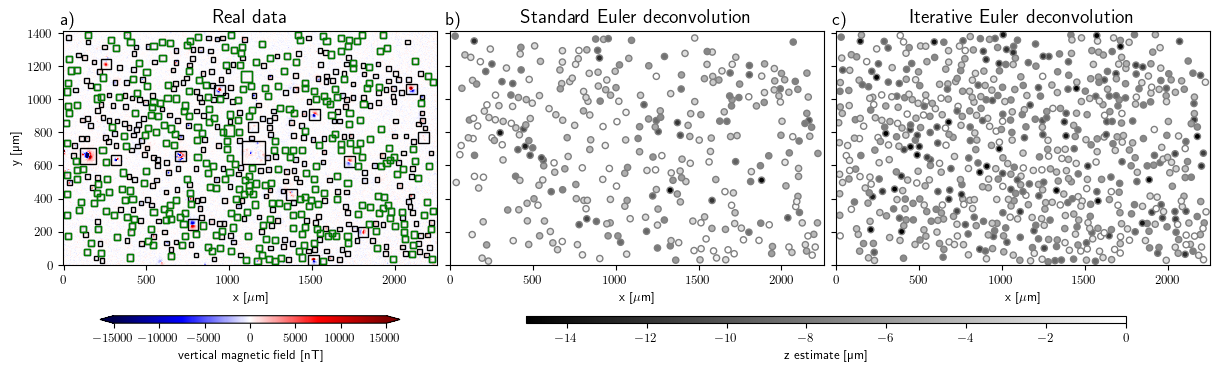

In [40]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

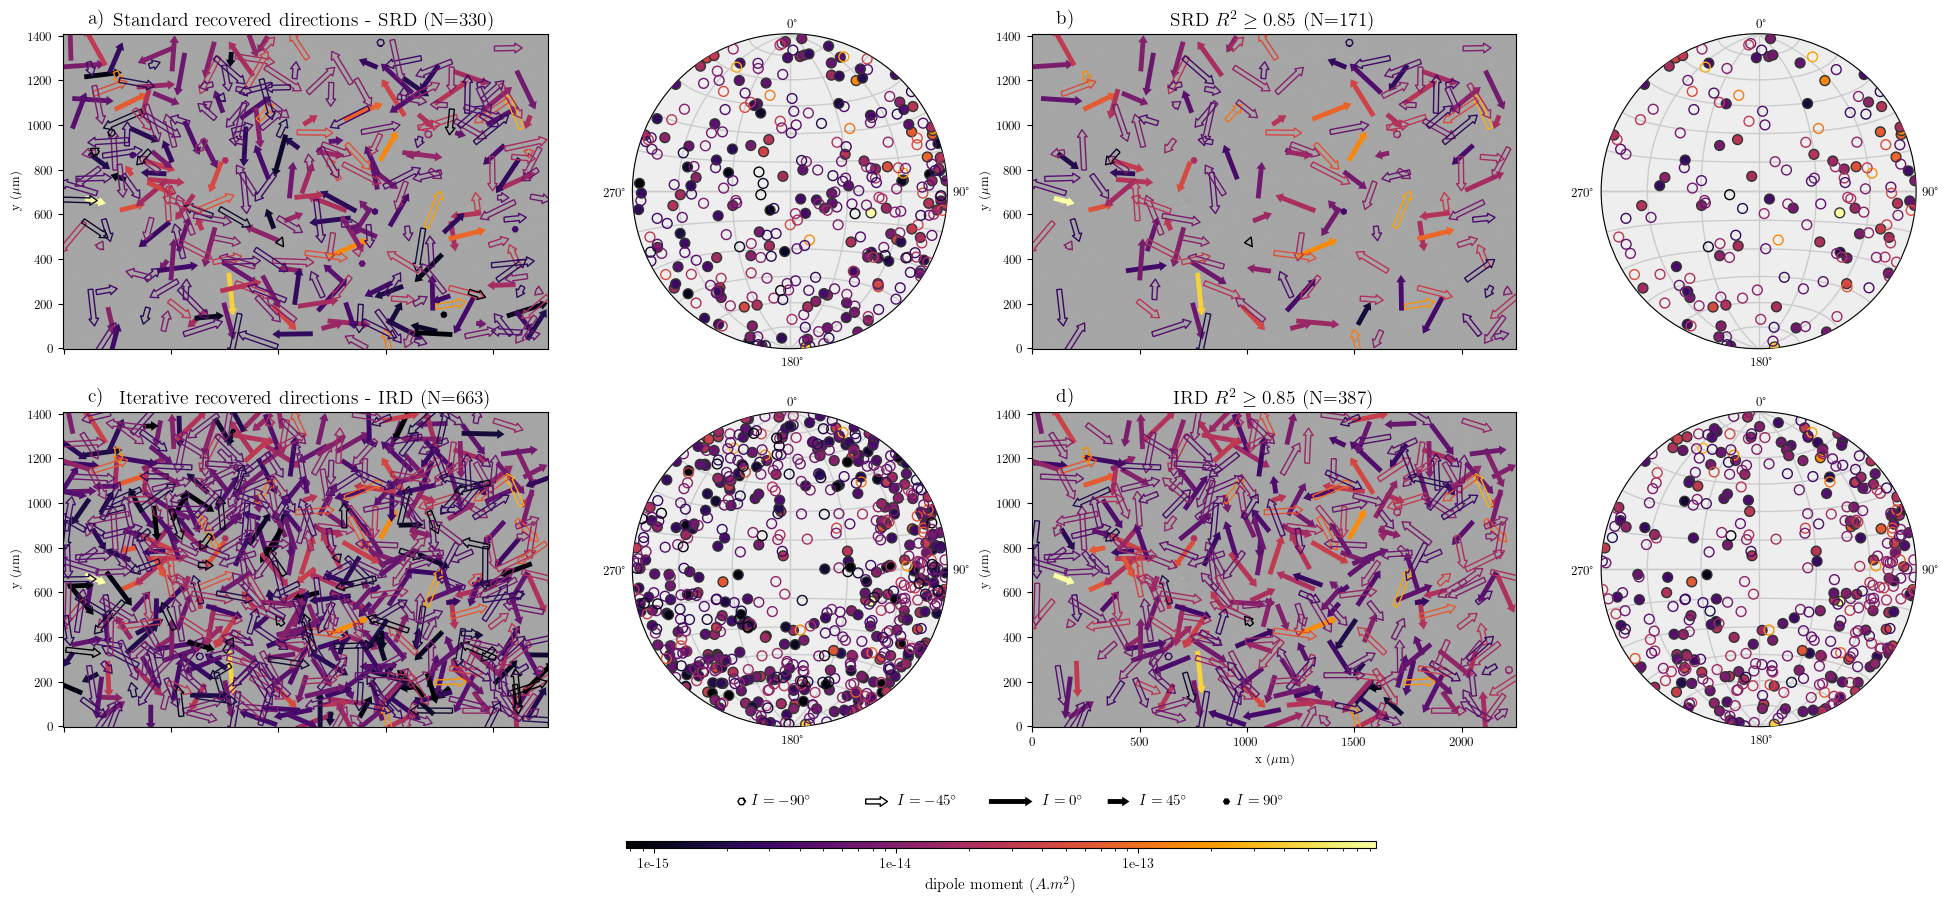

In [41]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

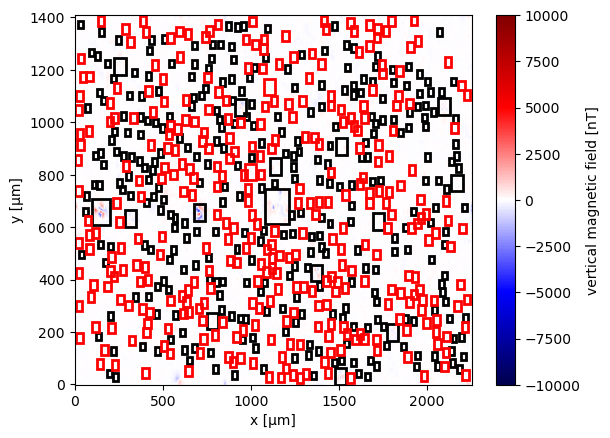

In [42]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [43]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.997665  ,  0.2309814 ,  0.99744708,  0.99444531,  0.97770815,
        0.90491361,  0.99779247,  0.99742527,  0.99934235,  0.99355117,
        0.80879949,  0.92328832,  0.99011496,  0.99444543,  0.95853025,
        0.95364065,  0.97492597,  0.93234532,  0.99201619,  0.93893307,
        0.98119463,  0.98408613,  0.97983743,  0.98623424,  0.99687207,
        0.98156703,  0.95258395,  0.97850311,  0.98874574,  0.98328258,
        0.99462012,  0.94899665,  0.98564065,  0.9831601 ,  0.93605955,
        0.98905385,  0.98772736,  0.99323681,  0.9785507 ,  0.92911587,
        0.95309828,  0.98338148,  0.96624181,  0.93310312,  0.98901997,
        0.99125577,  0.99843525,  0.98445198,  0.99304686,  0.99246388,
        0.96191598,  0.98574353,  0.97742883,  0.9915775 ,  0.97587012,
        0.35175759,  0.98084931,  0.98771725,  0.95142524,  0.91385864,
        0.97869348,  0.97841962,  0.99718037,  0.98691582,  0.99472275,
        0.41876846,  0.96827687,  0.9936697 ,  0.94150628,  0.97

# Show the observed and predicted data

In [44]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

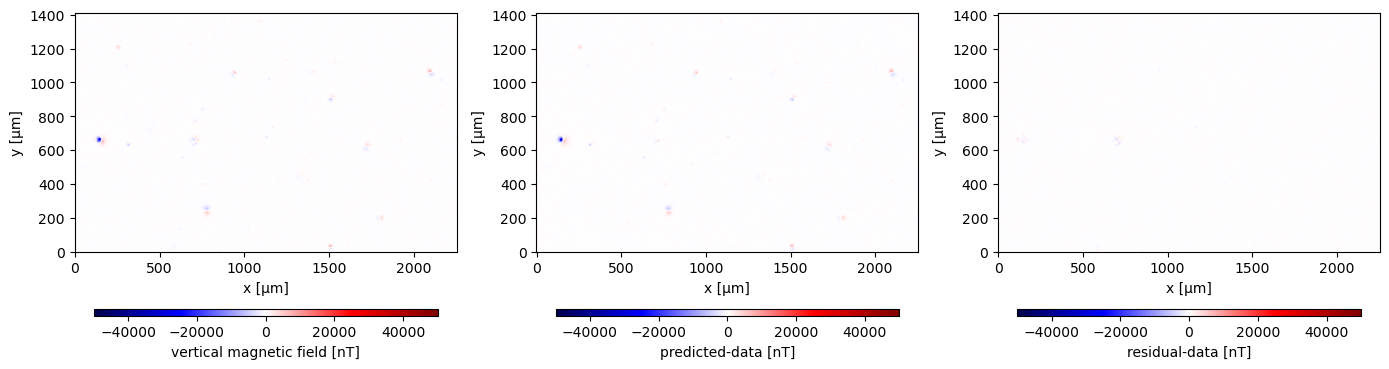

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +50000
    vmin = -50000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9976649962426728


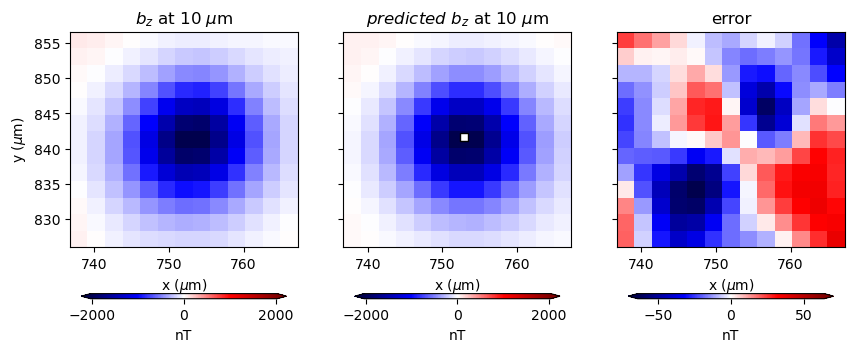

2
Individual source:   R2 = 0.2309814039481184


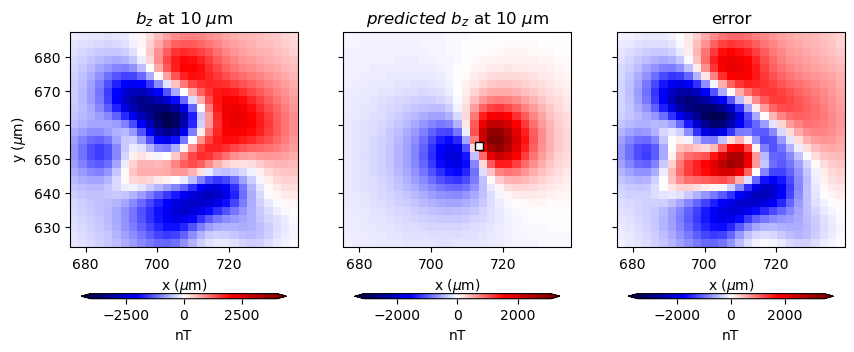

3
Individual source:   R2 = 0.9974470810084106


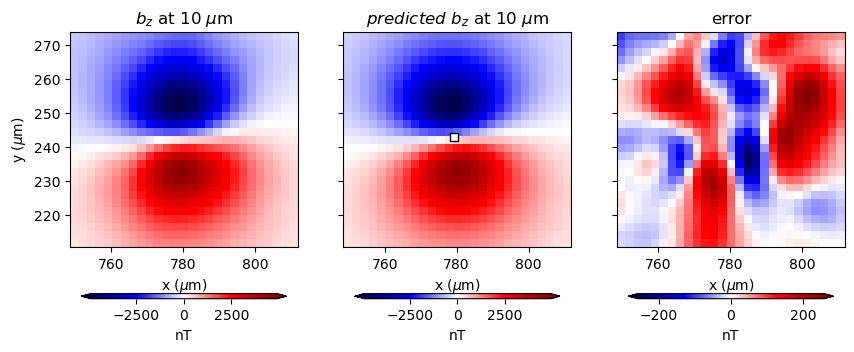

4
Individual source:   R2 = 0.9944453138498165


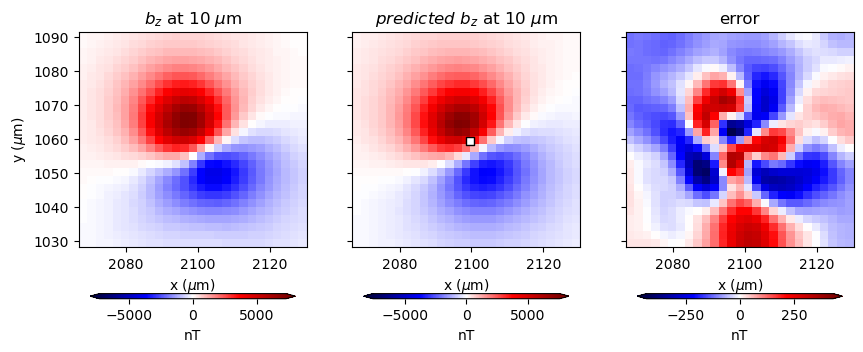

5
Individual source:   R2 = 0.977708153609461


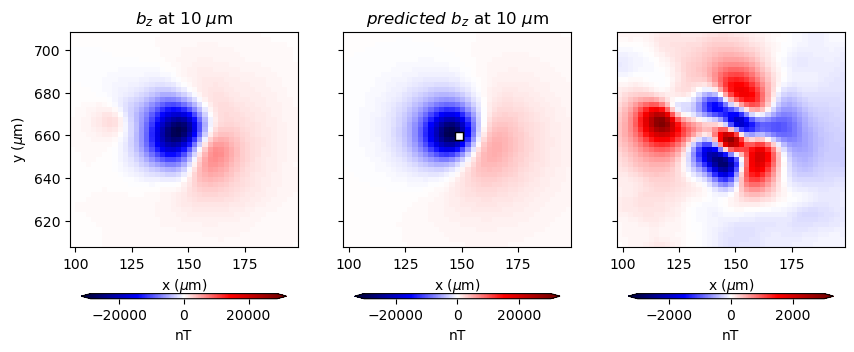

In [51]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [52]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [54]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)